In [52]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
import random
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [2]:
sentiment_analysis = pd.read_csv('sentiment_analysis.csv', index_col=0)

In [3]:
merged_data = pd.read_csv('merged_data.csv', index_col=0)

In [4]:
print(sentiment_analysis.head())

                   tweet_id           writer            post_date  \
2516889  947618374569353216          Auscomp  2018-01-01 00:00:01   
2516890  947618374569353216          Auscomp  2018-01-01 00:00:01   
2516891  947618475958325248  ExactOptionPick  2018-01-01 00:00:25   
2516892  947619846124122113          Eric714  2018-01-01 00:05:51   
2516893  947619846124122113          Eric714  2018-01-01 00:05:51   

                                                      body  comment_num  \
2516889  The 7 Greatest Tech Stocks of All Time monitor...            0   
2516890  The 7 Greatest Tech Stocks of All Time monitor...            0   
2516891  Don't miss our next FREE OPTION TRADE.  Sign u...            0   
2516892  How is $AAPL @Apple going to get me to buy a #...            1   
2516893  How is $AAPL @Apple going to get me to buy a #...            1   

         retweet_num  like_num ticker_symbol  sentiment  subjectivity  neg  \
2516889            0         2         GOOGL        1.0 

In [5]:
print(merged_data.head())

         Date Ticker  Adj Close      Close       High        Low       Open  \
0  2020-10-01   THRY  11.075000  11.075000  14.000000  10.600000  14.000000   
1  2020-10-01   WTRE  22.120148  24.570000  24.570000  24.440001  24.510000   
2  2020-10-01   SXTC   1.056000   1.056000   1.080000   0.976000   1.000000   
3  2020-10-01   MDJH   4.403000   4.403000   4.600000   4.100000   4.140000   
4  2020-10-01   BCOW   7.036474   7.036474   7.036474   7.036474   7.036474   

     Volume  Return_1d  Return_1w  ...  Return_1m_ndx  Return_3m_ndx  \
0    9600.0   0.888321   0.888321  ...      -0.057729       0.120027   
1   19300.0   0.011111   0.025459  ...      -0.057729       0.120027   
2  236375.0   0.077551   0.019305  ...      -0.057729       0.120027   
3   21600.0  -0.023725   0.081818  ...      -0.057729       0.120027   
4       0.0   0.000000  -0.019379  ...      -0.057729       0.120027   

   Return_6m_ndx  Return_1y_ndx Excess_Return_1d Excess_Return_1w  \
0       0.516987       

In [6]:
print(merged_data.columns)

Index(['Date', 'Ticker', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Return_1d', 'Return_1w', 'Return_1m', 'Return_3m', 'Return_6m',
       'Return_1y', 'Offer date', 'IPO name', 'CUSIP', 'Rollup', 'VC', 'Dual',
       'PostIssueShares', 'Internet', 'CRSP permanent ID', 'Founding',
       'IPO Price', 'Age at IPO', 'Return_1d_ndx', 'Return_1w_ndx',
       'Return_1m_ndx', 'Return_3m_ndx', 'Return_6m_ndx', 'Return_1y_ndx',
       'Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m',
       'Excess_Return_3m', 'Excess_Return_6m', 'Excess_Return_1y'],
      dtype='object')


In [7]:
merged_data.isnull().sum()

Date                      0
Ticker                    0
Adj Close                 0
Close                     0
High                      0
Low                       0
Open                      0
Volume                    0
Return_1d               318
Return_1w              1603
Return_1m              6755
Return_3m             20283
Return_6m             40632
Return_1y             81330
Offer date                0
IPO name                  0
CUSIP                     0
Rollup                    0
VC                        0
Dual                      0
PostIssueShares      175772
Internet                  0
CRSP permanent ID         0
Founding                  0
IPO Price                 0
Age at IPO                0
Return_1d_ndx             0
Return_1w_ndx             4
Return_1m_ndx            79
Return_3m_ndx           652
Return_6m_ndx          3671
Return_1y_ndx         16645
Excess_Return_1d        318
Excess_Return_1w       1603
Excess_Return_1m       6755
Excess_Return_3m    

###  Aggregate the sentiment data
We have multiple tweets on the same date and one or more IPOs for each date. Therefore we will aggregate the sentiment data for each date based on the mean sentiment of tweets for each date.

Convert the date columns to the same format.

In [8]:
sentiment_analysis['post_date'] = pd.to_datetime(sentiment_analysis['post_date']).dt.date

In [9]:
twitter_aggregated = sentiment_analysis.groupby('post_date').agg({
    'sentiment': 'mean',
    'subjectivity': 'mean',
    'neg': 'mean',
    'neu': 'mean',
    'pos': 'mean',
    'compound': 'mean'
}).reset_index()


In [10]:
print(twitter_aggregated.head())

    post_date  sentiment  subjectivity       neg       neu       pos  compound
0  2018-01-01   0.132086      0.356609  0.015499  0.860219  0.124289  0.272382
1  2018-01-02   0.128009      0.339031  0.022165  0.873140  0.104692  0.203102
2  2018-01-03   0.108937      0.314095  0.032379  0.874070  0.093552  0.152989
3  2018-01-04   0.117732      0.367053  0.039688  0.849643  0.110658  0.182246
4  2018-01-05   0.138767      0.380356  0.024531  0.884228  0.091244  0.170037


### Sentiment Analysis Lookback period 

In [11]:
common_dates = set(twitter_aggregated['post_date']).intersection(set(merged_data['Date']))
print(f"Number of common dates: {len(common_dates)}")

Number of common dates: 0


Seems like we have no matching dates between our two datasets

For our analysis, considering sentiment from a period leading up to the IPO date may be more informative. For example, the sentiment in the week or month leading up to the IPO could impact investor expectations and thus the IPO performance. 

In [12]:
# Group by 'Date' and count the number of unique 'Ticker' values
ipo_per_date = merged_data.groupby('Date')['Ticker'].nunique()

# Check if there are any dates with more than one IPO
multiple_ipos = ipo_per_date[ipo_per_date > 1]

print(f"Number of dates with multiple IPOs: {len(multiple_ipos)}")

Number of dates with multiple IPOs: 1111


In [13]:
# Display dates with more than one IPO
print(multiple_ipos)

# Examine one of these dates in more detail
example_date = multiple_ipos.index[0]
print(merged_data[merged_data['Date'] == example_date])

Date
2019-01-08      2
2019-01-09      4
2019-01-10      4
2019-01-11      4
2019-01-14      4
             ... 
2023-05-31    320
2023-06-01    320
2023-06-02    319
2023-06-05    319
2023-06-06    319
Name: Ticker, Length: 1111, dtype: int64
              Date Ticker  Adj Close      Close   High        Low       Open  \
265926  2019-01-08   SXTC  26.040001  26.040001  28.00  24.200001  25.799999   
265927  2019-01-08   MDJH   4.700000   4.700000   4.99   4.400000   4.750000   

         Volume  Return_1d  Return_1w  ...  Return_1m_ndx  Return_3m_ndx  \
265926   5650.0   0.065466        NaN  ...            NaN            NaN   
265927  34700.0        NaN        NaN  ...            NaN            NaN   

        Return_6m_ndx  Return_1y_ndx Excess_Return_1d Excess_Return_1w  \
265926            NaN            NaN         0.055664              NaN   
265927            NaN            NaN              NaN              NaN   

       Excess_Return_1m Excess_Return_3m  Excess_Return_6m  Exc

In [14]:
# Convert 'Date' to datetime
merged_data['Date'] = pd.to_datetime(merged_data['Date']).dt.date

# Ensure 'post_date' is also in datetime.date format
twitter_aggregated['post_date'] = pd.to_datetime(twitter_aggregated['post_date']).dt.date

In [15]:
def get_aggregated_data(lookback_days):
    # Define the period of interest
    lookback_period = pd.Timedelta(days=lookback_days)

    # Create a new DataFrame to hold the aggregated data
    aggregated_data = pd.DataFrame()

    # Loop over IPO dates
    for ipo_date in merged_data['Date'].unique():
        # Select tweets from the period leading up to the IPO
        mask = (twitter_aggregated['post_date'] >= ipo_date - lookback_period) & (twitter_aggregated['post_date'] < ipo_date)
        selected_tweets = twitter_aggregated.loc[mask]

        # Skip if there are no selected tweets
        if selected_tweets.empty:
            continue

        # Calculate mean sentiment metrics for the selected tweets
        aggregated_row = selected_tweets.agg({
            'sentiment': 'mean',
            'subjectivity': 'mean',
            'neg': 'mean',
            'neu': 'mean',
            'pos': 'mean',
            'compound': 'mean'
        })

        # Add the IPO date to the aggregated row
        aggregated_row['Date'] = ipo_date

        # Append the aggregated row to the DataFrame
        aggregated_data = pd.concat([aggregated_data, pd.DataFrame(aggregated_row).T], ignore_index=True)
        
    # return the resulting dataframe
    return aggregated_data

# Now you can create different variables for different lookback periods
aggregated_data_7_days = get_aggregated_data(7)
aggregated_data_14_days = get_aggregated_data(14)
aggregated_data_30_days = get_aggregated_data(30)
aggregated_data_45_days = get_aggregated_data(45)

In [16]:
print(aggregated_data_14_days.head())

  sentiment subjectivity       neg       neu       pos  compound        Date
0  0.112359     0.376524  0.046038  0.846241  0.107721  0.157272  2019-03-28
1  0.112253     0.375571  0.046101  0.846212  0.107686   0.15729  2019-03-29
2  0.115261     0.373016   0.04437  0.847611  0.108019  0.161779  2019-04-01
3  0.114878      0.37219  0.044699  0.847903  0.107398  0.159317  2019-04-02
4  0.115948     0.371172  0.044129  0.849144  0.106727  0.160929  2019-04-03


In [17]:
print(aggregated_data_30_days.head())

  sentiment subjectivity       neg       neu       pos  compound        Date
0  0.110364     0.379554  0.046939  0.845792  0.107268  0.156603  2019-03-28
1   0.11132     0.379025  0.046452  0.846334  0.107212  0.158254  2019-03-29
2  0.114598     0.379613  0.045573  0.846413  0.108015  0.162866  2019-04-01
3  0.114644     0.378412  0.045267  0.847384  0.107349  0.161782  2019-04-02
4  0.115166     0.377423  0.044862  0.848073  0.107064  0.161853  2019-04-03


### Merge the DataFrames

In [18]:
# Rename the columns before merging
aggregated_data_7_days.columns = [f"{col}_7_days" if col != 'Date' else col for col in aggregated_data_7_days.columns]
aggregated_data_14_days.columns = [f"{col}_14_days" if col != 'Date' else col for col in aggregated_data_14_days.columns]
aggregated_data_30_days.columns = [f"{col}_30_days" if col != 'Date' else col for col in aggregated_data_30_days.columns]
aggregated_data_45_days.columns = [f"{col}_45_days" if col != 'Date' else col for col in aggregated_data_45_days.columns]

# Merge the aggregated_data_7_days
merged_data = pd.merge(merged_data, aggregated_data_7_days, how='left', on='Date')

# Merge the aggregated_data_14_days
merged_data = pd.merge(merged_data, aggregated_data_14_days, how='left', on='Date')

# Merge the aggregated_data_30_days
merged_data = pd.merge(merged_data, aggregated_data_30_days, how='left', on='Date')

# Merge the aggregated_data_45_days
merged_data = pd.merge(merged_data, aggregated_data_45_days, how='left', on='Date')


In [19]:
print(merged_data.head())

         Date Ticker  Adj Close      Close       High        Low       Open  \
0  2020-10-01   THRY  11.075000  11.075000  14.000000  10.600000  14.000000   
1  2020-10-01   WTRE  22.120148  24.570000  24.570000  24.440001  24.510000   
2  2020-10-01   SXTC   1.056000   1.056000   1.080000   0.976000   1.000000   
3  2020-10-01   MDJH   4.403000   4.403000   4.600000   4.100000   4.140000   
4  2020-10-01   BCOW   7.036474   7.036474   7.036474   7.036474   7.036474   

     Volume  Return_1d  Return_1w  ...  neg_30_days  neu_30_days  pos_30_days  \
0    9600.0   0.888321   0.888321  ...          NaN          NaN          NaN   
1   19300.0   0.011111   0.025459  ...          NaN          NaN          NaN   
2  236375.0   0.077551   0.019305  ...          NaN          NaN          NaN   
3   21600.0  -0.023725   0.081818  ...          NaN          NaN          NaN   
4       0.0   0.000000  -0.019379  ...          NaN          NaN          NaN   

   compound_30_days sentiment_45_days 

In [20]:
print(merged_data.columns)

Index(['Date', 'Ticker', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       'Return_1d', 'Return_1w', 'Return_1m', 'Return_3m', 'Return_6m',
       'Return_1y', 'Offer date', 'IPO name', 'CUSIP', 'Rollup', 'VC', 'Dual',
       'PostIssueShares', 'Internet', 'CRSP permanent ID', 'Founding',
       'IPO Price', 'Age at IPO', 'Return_1d_ndx', 'Return_1w_ndx',
       'Return_1m_ndx', 'Return_3m_ndx', 'Return_6m_ndx', 'Return_1y_ndx',
       'Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m',
       'Excess_Return_3m', 'Excess_Return_6m', 'Excess_Return_1y',
       'sentiment_7_days', 'subjectivity_7_days', 'neg_7_days', 'neu_7_days',
       'pos_7_days', 'compound_7_days', 'sentiment_14_days',
       'subjectivity_14_days', 'neg_14_days', 'neu_14_days', 'pos_14_days',
       'compound_14_days', 'sentiment_30_days', 'subjectivity_30_days',
       'neg_30_days', 'neu_30_days', 'pos_30_days', 'compound_30_days',
       'sentiment_45_days', 'subjectivity_45_days', 'neg_45_da

### More Data Cleaning... 

Drop unnecessary columns 

In [21]:
# List of columns to drop
columns_to_drop = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CUSIP', 'CRSP permanent ID', 'PostIssueShares', 'IPO name', 'Founding', 'Return_1d_ndx',
       'Return_1w_ndx', 'Return_1m_ndx', 'Return_3m_ndx', 'Return_6m_ndx', 'Return_1y_ndx', 'Return_1d', 'Return_1w', 'Return_1m', 'Return_3m', 'Return_6m',
       'Return_1y', ]

# Drop columns
merged_data = merged_data.drop(columns_to_drop, axis=1)


In [22]:
print(merged_data.columns)

Index(['Date', 'Ticker', 'Offer date', 'Rollup', 'VC', 'Dual', 'Internet',
       'IPO Price', 'Age at IPO', 'Excess_Return_1d', 'Excess_Return_1w',
       'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m',
       'Excess_Return_1y', 'sentiment_7_days', 'subjectivity_7_days',
       'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
       'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
       'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
       'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
       'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
       'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days'],
      dtype='object')


#### Variable Rollout still has some '.' instead of '0'

In [23]:
# Change '.' to '0' in 'Rollup' column
merged_data['Rollup'] = merged_data['Rollup'].replace('.', '0')


In [24]:
merged_data['Rollup'] = merged_data['Rollup'].astype(float)


In [25]:
print(merged_data.dtypes)

Date                     object
Ticker                   object
Offer date               object
Rollup                  float64
VC                      float64
Dual                    float64
Internet                float64
IPO Price               float64
Age at IPO                int64
Excess_Return_1d        float64
Excess_Return_1w        float64
Excess_Return_1m        float64
Excess_Return_3m        float64
Excess_Return_6m        float64
Excess_Return_1y        float64
sentiment_7_days         object
subjectivity_7_days      object
neg_7_days               object
neu_7_days               object
pos_7_days               object
compound_7_days          object
sentiment_14_days        object
subjectivity_14_days     object
neg_14_days              object
neu_14_days              object
pos_14_days              object
compound_14_days         object
sentiment_30_days        object
subjectivity_30_days     object
neg_30_days              object
neu_30_days              object
pos_30_d

### Convert sentiment variables to numeric using the pd.to_numeric()


In [26]:
sentiment_vars = [
    'sentiment_7_days',
    'subjectivity_7_days',
    'neg_7_days',
    'neu_7_days',
    'pos_7_days',
    'compound_7_days',
    'sentiment_14_days',
    'subjectivity_14_days',
    'neg_14_days',
    'neu_14_days',
    'pos_14_days',
    'compound_14_days',
    'sentiment_30_days',
    'subjectivity_30_days',
    'neg_30_days',
    'neu_30_days',
    'pos_30_days',
    'compound_30_days',
    'sentiment_45_days',
    'subjectivity_45_days',
    'neg_45_days',
    'neu_45_days',
    'pos_45_days',
    'compound_45_days'
]


for column in sentiment_vars:
    merged_data[column] = pd.to_numeric(merged_data[column], errors='coerce')



In [27]:
print(merged_data.dtypes)

Date                     object
Ticker                   object
Offer date               object
Rollup                  float64
VC                      float64
Dual                    float64
Internet                float64
IPO Price               float64
Age at IPO                int64
Excess_Return_1d        float64
Excess_Return_1w        float64
Excess_Return_1m        float64
Excess_Return_3m        float64
Excess_Return_6m        float64
Excess_Return_1y        float64
sentiment_7_days        float64
subjectivity_7_days     float64
neg_7_days              float64
neu_7_days              float64
pos_7_days              float64
compound_7_days         float64
sentiment_14_days       float64
subjectivity_14_days    float64
neg_14_days             float64
neu_14_days             float64
pos_14_days             float64
compound_14_days        float64
sentiment_30_days       float64
subjectivity_30_days    float64
neg_30_days             float64
neu_30_days             float64
pos_30_d

All variables are now in numeric form, so we can now do a correlation matrix

In [28]:
excess_return_vars = [
    'Excess_Return_1d',
    'Excess_Return_1w',
    'Excess_Return_1m',
    'Excess_Return_3m',
    'Excess_Return_6m'
]

correlation_matrix = merged_data[sentiment_vars + excess_return_vars].corr()
correlation_with_excess_returns = correlation_matrix[excess_return_vars]


In [29]:
print(correlation_with_excess_returns)

                      Excess_Return_1d  Excess_Return_1w  Excess_Return_1m  \
sentiment_7_days              0.022915          0.036228          0.057457   
subjectivity_7_days           0.003151          0.004799          0.054609   
neg_7_days                   -0.011487         -0.035908         -0.031498   
neu_7_days                    0.004484          0.021849          0.015195   
pos_7_days                   -0.000670         -0.011349         -0.004722   
compound_7_days               0.010539          0.017947          0.027622   
sentiment_14_days             0.024194          0.047758          0.084525   
subjectivity_14_days          0.003679          0.003428          0.054366   
neg_14_days                  -0.020955         -0.045057         -0.057134   
neu_14_days                   0.005800          0.019308          0.016611   
pos_14_days                   0.000631         -0.006646          0.001500   
compound_14_days              0.015489          0.026425        

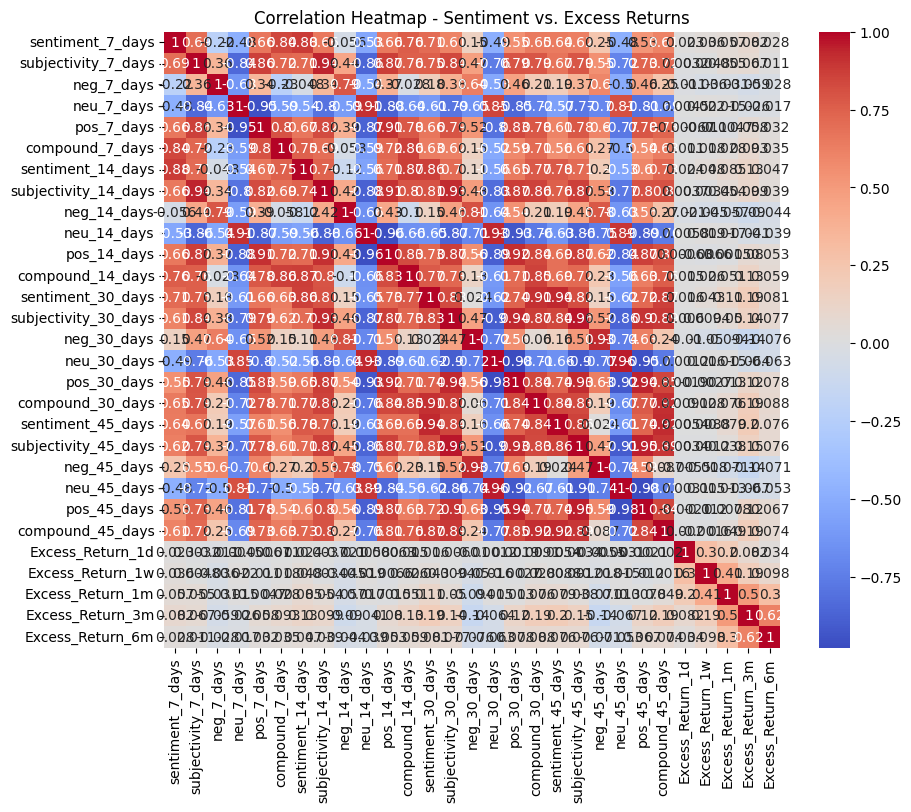

In [30]:
correlation_matrix = merged_data[sentiment_vars + excess_return_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, square=True)
plt.title('Correlation Heatmap - Sentiment vs. Excess Returns')
plt.show()

## Missing Values 

In [31]:
print(merged_data.isnull().sum())

Date                         0
Ticker                       0
Offer date                   0
Rollup                       0
VC                           0
Dual                         0
Internet                     0
IPO Price                    0
Age at IPO                   0
Excess_Return_1d           318
Excess_Return_1w          1603
Excess_Return_1m          6755
Excess_Return_3m         20283
Excess_Return_6m         40632
Excess_Return_1y         81330
sentiment_7_days        249312
subjectivity_7_days     249312
neg_7_days              249312
neu_7_days              249312
pos_7_days              249312
compound_7_days         249312
sentiment_14_days       248642
subjectivity_14_days    248642
neg_14_days             248642
neu_14_days             248642
pos_14_days             248642
compound_14_days        248642
sentiment_30_days       247138
subjectivity_30_days    247138
neg_30_days             247138
neu_30_days             247138
pos_30_days             247138
compound

Missing values for excess returns are expected for certain periods due to the nature of the data. For example, a company can't have a one-week excess return on the day of its IPO, because it hasn't been publicly traded for a week yet. This is not a "missing" value in the traditional sense, but rather a natural consequence of the temporal nature of the data.

In [32]:
# Get IPOs with non-null sentiment data
ipos_with_sentiment_data = merged_data[~merged_data['sentiment_7_days'].isnull()]['Ticker'].unique()

# Print IPOs with sentiment data
print(ipos_with_sentiment_data)
print(len(ipos_with_sentiment_data))

['WTRE' 'SXTC' 'MDJH' 'BCOW' 'MTC' 'RBKB' 'NFE' 'INMB' 'ALEC' 'GOSS'
 'HARP' 'TCRR' 'HOTH' 'SLGG' 'KLDO' 'SWAV' 'TIGR' 'LEVI' 'DTIL' 'LYFT'
 'PUYI' 'PBTS' 'NGM' 'SILK' 'TW' 'GHSI' 'PD' 'PLMR' 'GNLN' 'HOOK' 'PINS'
 'ZM' 'WAFU' 'BYND' 'SY' 'TMDX' 'ATIF' 'RRBI' 'SCPL' 'YJ' 'TRVI' 'PSN'
 'AXLA' 'HHR' 'MEC' 'NXTC' 'SPFI' 'JFIN' 'SONM' 'UBER' 'APLT' 'PSTL'
 'AVTR' 'FSLY' 'BCYC' 'IDYA' 'RTLR' 'RVLV' 'CRWD' 'FVRR' 'CHWY' 'STOK'
 'AKRO' 'BCEL' 'GO' 'PSNL' 'CMBM' 'ADPT' 'BBIO' 'MORF' 'KRTX' 'REAL'
 'DOYU' 'AMK' 'FULC' 'MIRM' 'ORCC' 'PHR' 'AFYA' 'EIC' 'CSTL' 'HCAT' 'NOVA'
 'BHAT' 'DT' 'KRUS' 'SNDL' 'INMD' 'CFB' 'SDC' 'TXG' 'NET' 'STSA' 'SWTX'
 'IGMS' 'NVST' 'DDOG' 'XGN' 'OPRT' 'PTON' 'APRE' 'FREQ' 'BNTX' 'HBT' 'VIR'
 'BRBR' 'BRP' 'AIH' 'CABA' 'DAO' 'PGNY' 'PHAT' 'TFFP' 'RAPT' 'DUO' 'CNTG'
 'GRTX' 'SI' 'CNSP' 'KRKR' 'TELA' 'ETNB' 'YAYO' 'CAN' 'SITM' 'PINE' 'LMPX'
 'XP' 'BILL' 'EH' 'OCFT' 'SPT' 'INDO' 'MNPR']
134


In [33]:
# Get IPOs with non-null sentiment data
ipos_with_sentiment_data_45 = merged_data[~merged_data['sentiment_45_days'].isnull()]['Ticker'].unique()

# Print IPOs with sentiment data
print(ipos_with_sentiment_data_45)
print(len(ipos_with_sentiment_data_45))

['WTRE' 'SXTC' 'MDJH' 'BCOW' 'MTC' 'RBKB' 'NFE' 'INMB' 'ALEC' 'GOSS'
 'HARP' 'TCRR' 'HOTH' 'SLGG' 'KLDO' 'SWAV' 'TIGR' 'LEVI' 'DTIL' 'LYFT'
 'PUYI' 'PBTS' 'NGM' 'SILK' 'TW' 'GHSI' 'PD' 'PLMR' 'GNLN' 'HOOK' 'PINS'
 'ZM' 'WAFU' 'BYND' 'SY' 'TMDX' 'ATIF' 'RRBI' 'SCPL' 'YJ' 'TRVI' 'PSN'
 'AXLA' 'HHR' 'MEC' 'NXTC' 'SPFI' 'JFIN' 'SONM' 'UBER' 'APLT' 'PSTL'
 'AVTR' 'FSLY' 'BCYC' 'IDYA' 'RTLR' 'RVLV' 'CRWD' 'FVRR' 'CHWY' 'STOK'
 'AKRO' 'BCEL' 'GO' 'PSNL' 'CMBM' 'ADPT' 'BBIO' 'MORF' 'KRTX' 'REAL'
 'DOYU' 'AMK' 'FULC' 'MIRM' 'ORCC' 'PHR' 'AFYA' 'EIC' 'CSTL' 'HCAT' 'NOVA'
 'BHAT' 'DT' 'KRUS' 'SNDL' 'INMD' 'CFB' 'SDC' 'TXG' 'NET' 'STSA' 'SWTX'
 'IGMS' 'NVST' 'DDOG' 'XGN' 'OPRT' 'PTON' 'APRE' 'FREQ' 'BNTX' 'HBT' 'VIR'
 'BRBR' 'BRP' 'AIH' 'CABA' 'DAO' 'PGNY' 'PHAT' 'TFFP' 'RAPT' 'DUO' 'CNTG'
 'GRTX' 'SI' 'CNSP' 'KRKR' 'TELA' 'ETNB' 'YAYO' 'CAN' 'SITM' 'PINE' 'LMPX'
 'XP' 'BILL' 'EH' 'OCFT' 'SPT' 'INDO' 'MNPR' 'IMAB' 'LIZI' 'VEL' 'ANVS'
 'ANPC' 'ARQT' 'BDTX' 'REYN' 'BEAM' 'SDGR' 'NREF' 'ONEW' 'HUIZ' 

We only have sentiment analysis data for 134 of our IPOs. Given the large number of missing values in the sentiment variebles, we will proceed to drop rows where sentiment is missing

In [34]:
# Drop rows where sentiment variables are missing
df_clean = merged_data.dropna(subset=['sentiment_7_days', 'sentiment_14_days', 'sentiment_30_days', 'sentiment_45_days'])

# Display the first few rows of the cleaned dataframe
print(df_clean.head())


              Date Ticker  Offer date  Rollup   VC  Dual  Internet  IPO Price  \
216659  2019-03-28   WTRE  2019-03-28     0.0  0.0   0.0       0.0      25.26   
216660  2019-03-28   SXTC  2019-01-04     0.0  0.0   0.0       0.0       4.00   
216661  2019-03-28   MDJH  2019-01-08     0.0  0.0   0.0       0.0       5.00   
216662  2019-03-28   BCOW  2019-01-09     0.0  0.0   0.0       0.0      10.00   
216663  2019-03-28    MTC  2019-01-08     0.0  0.0   0.0       0.0       4.00   

        Age at IPO  Excess_Return_1d  ...  neg_30_days  neu_30_days  \
216659           5          0.000208  ...     0.046939     0.845792   
216660          13         -0.009199  ...     0.046939     0.845792   
216661           5         -0.020120  ...     0.046939     0.845792   
216662          24          0.000375  ...     0.046939     0.845792   
216663          63         -0.014285  ...     0.046939     0.845792   

        pos_30_days  compound_30_days  sentiment_45_days  \
216659     0.107268       

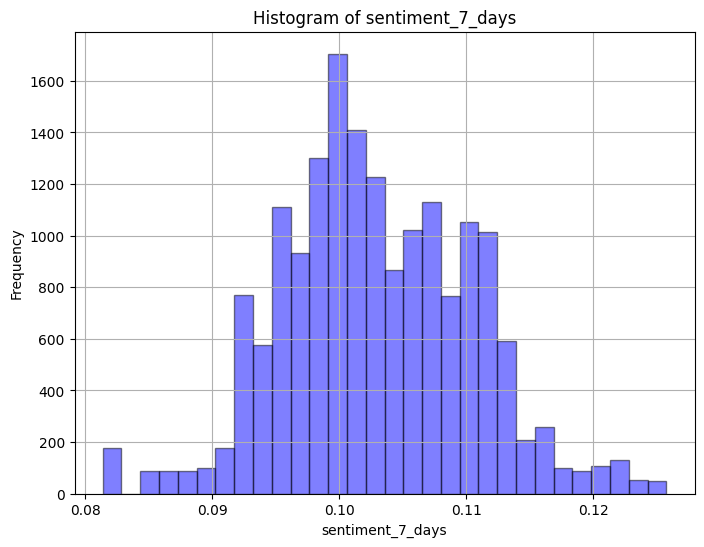

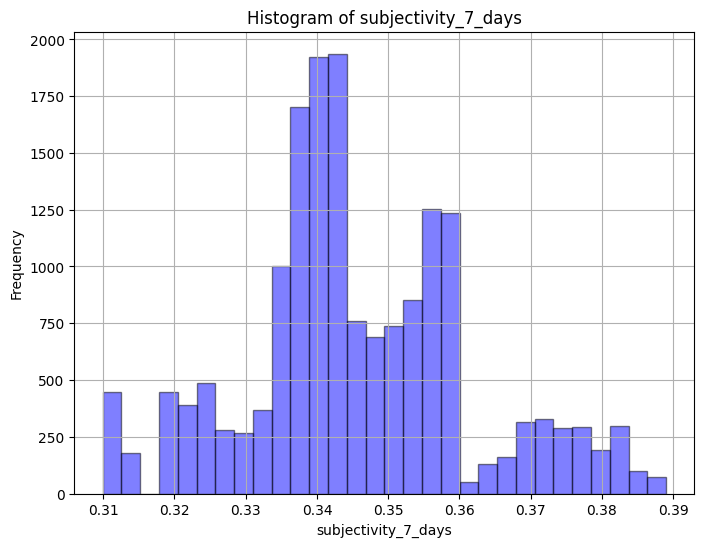

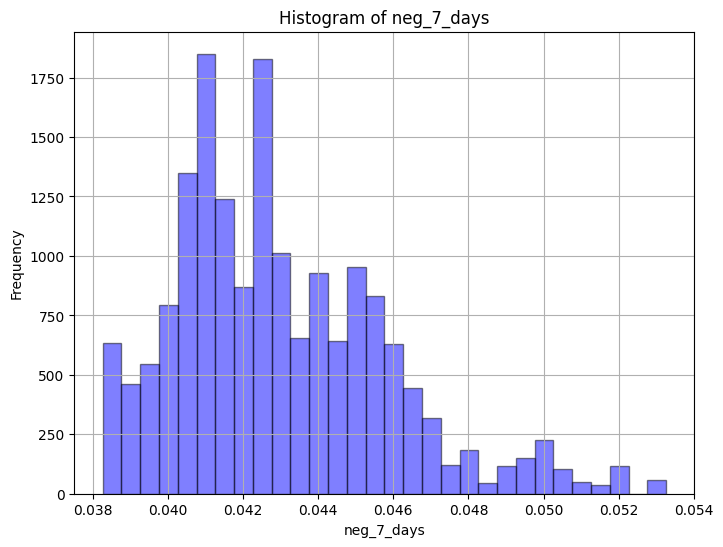

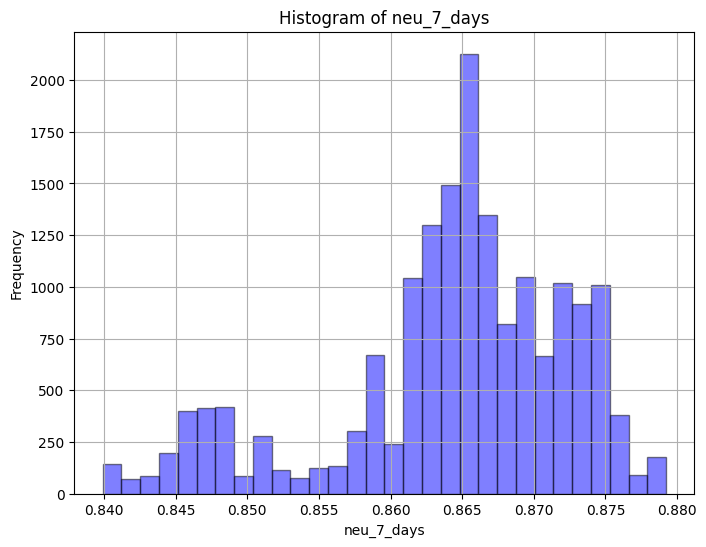

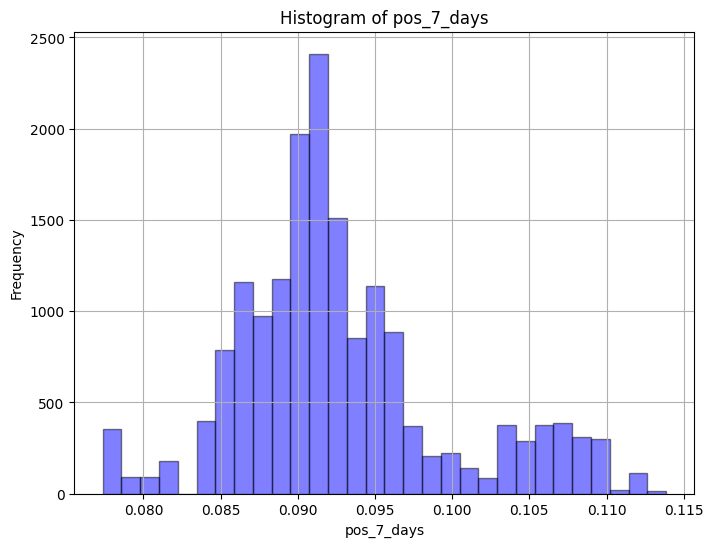

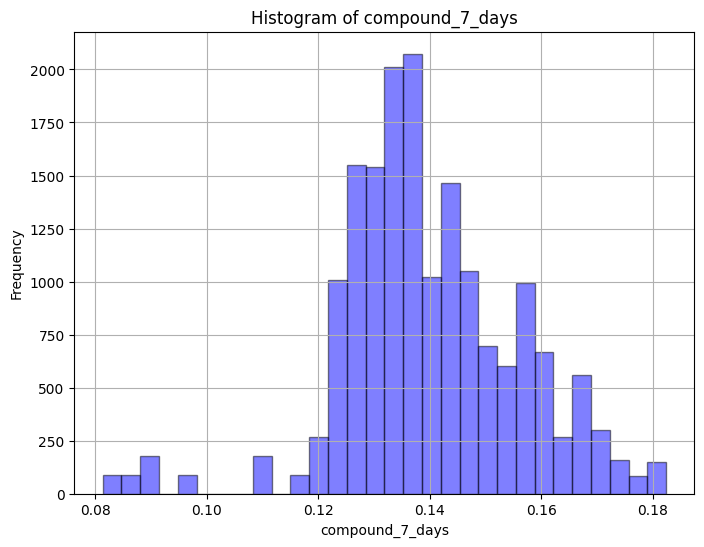

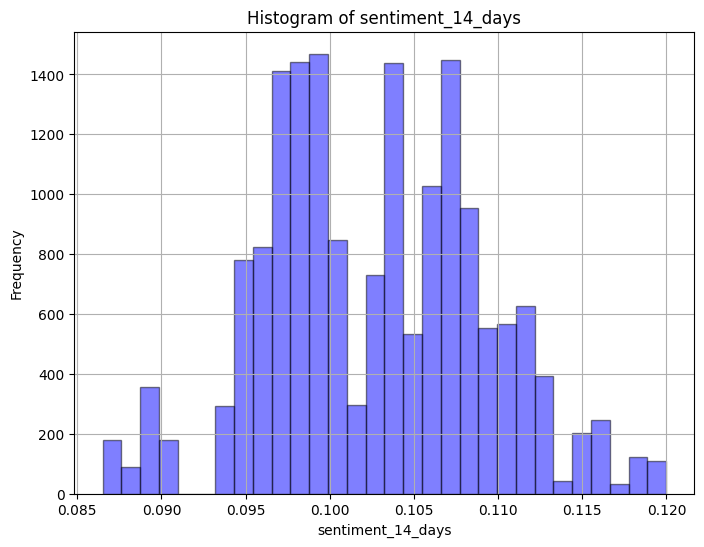

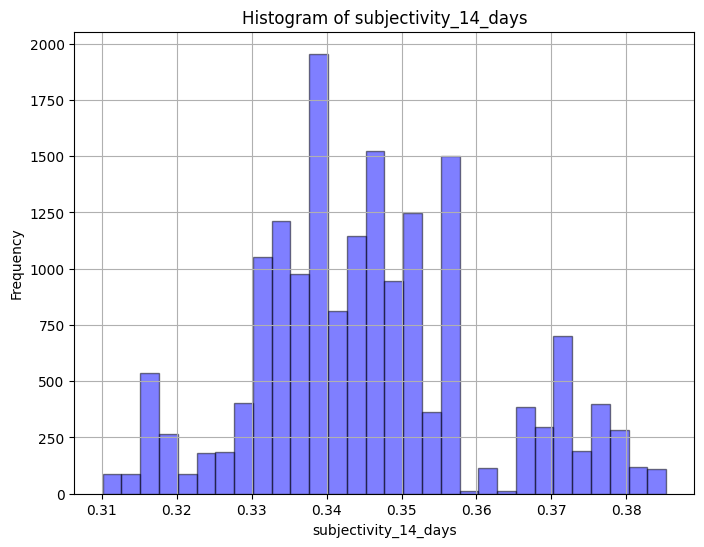

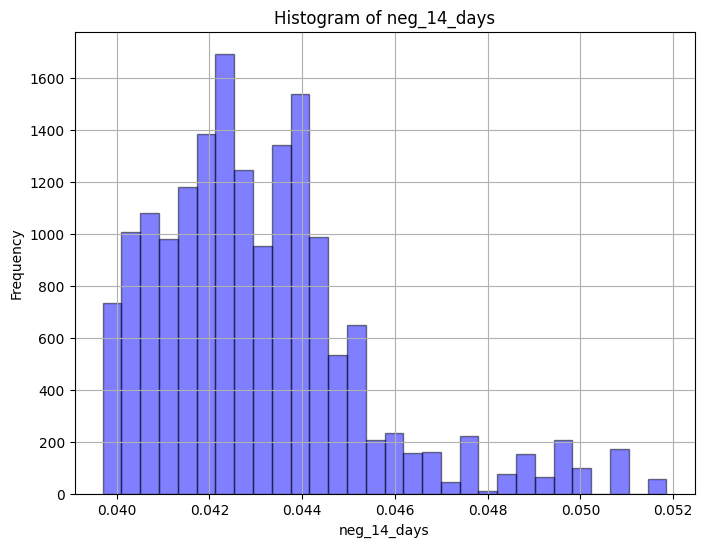

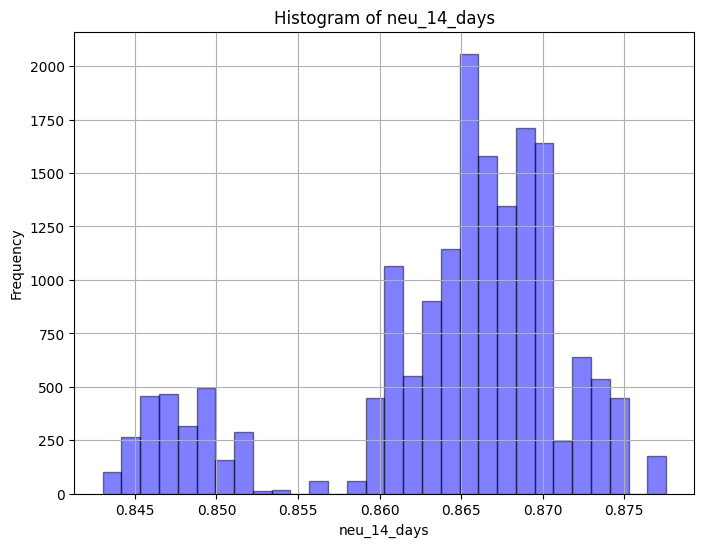

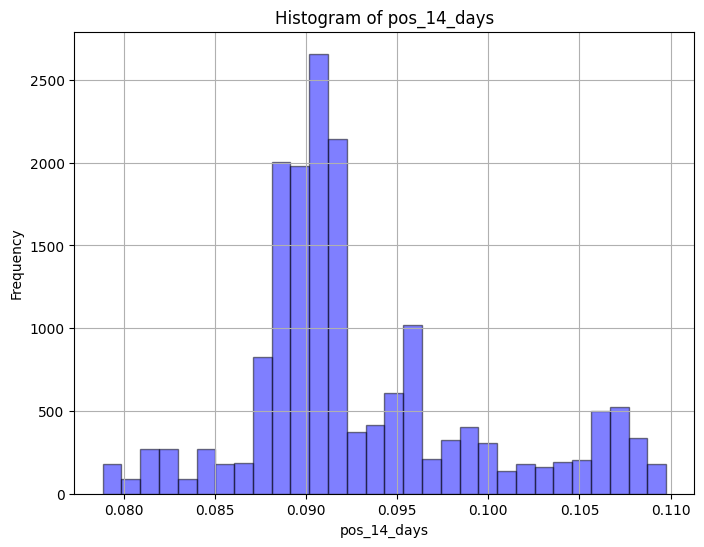

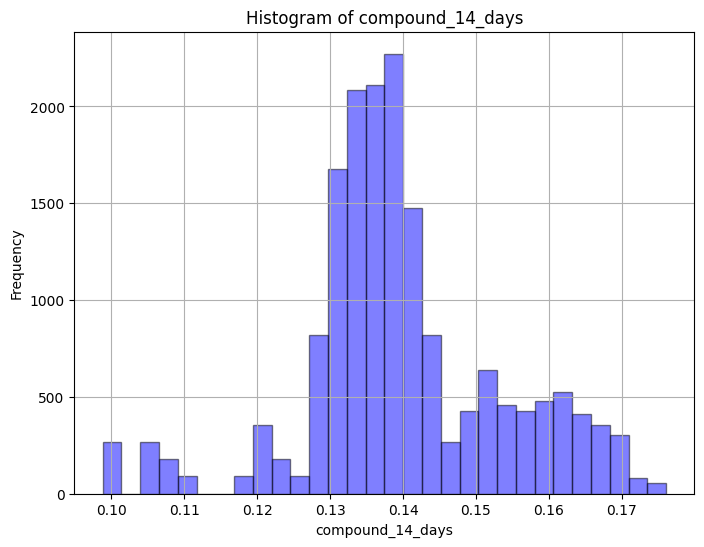

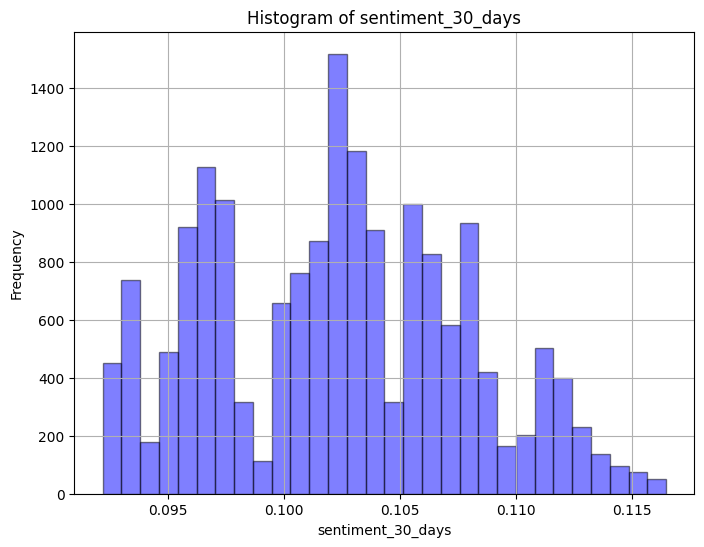

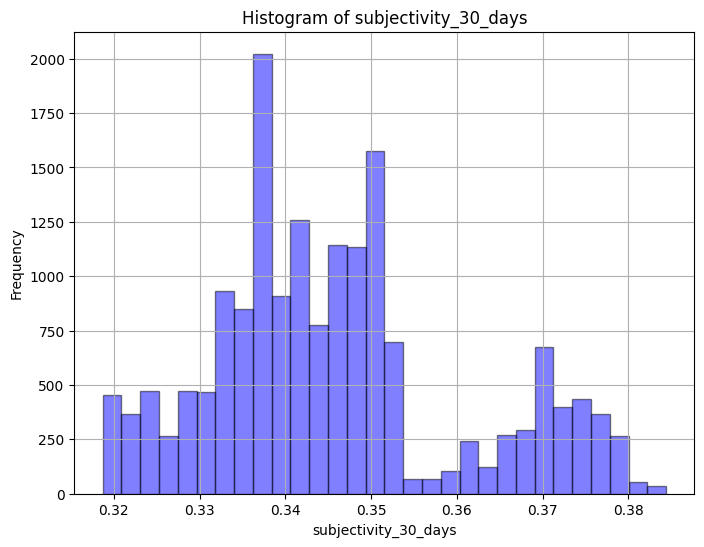

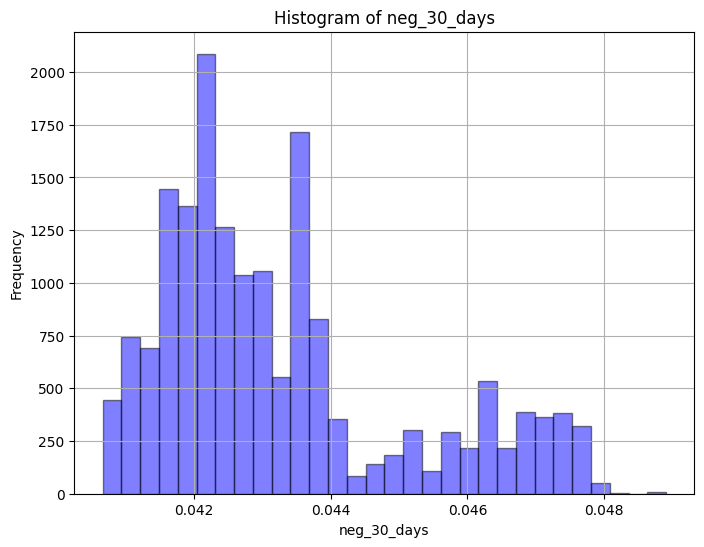

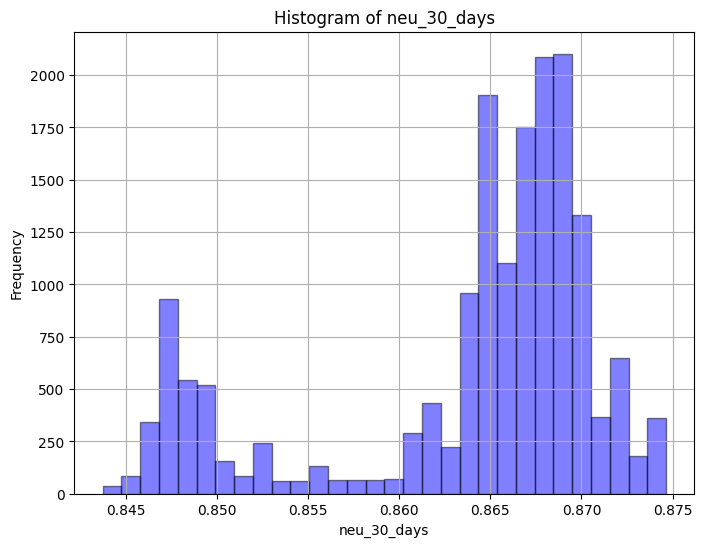

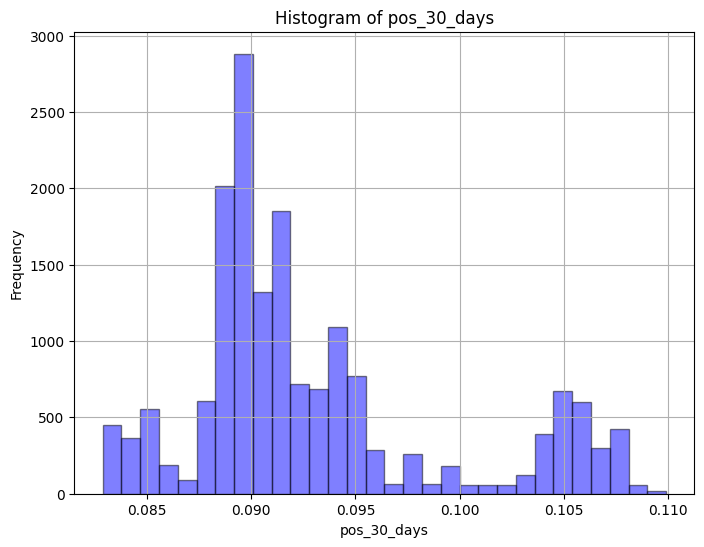

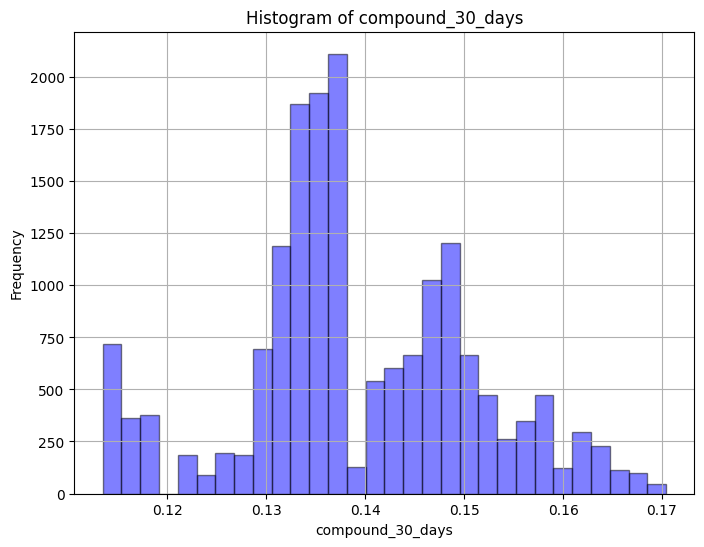

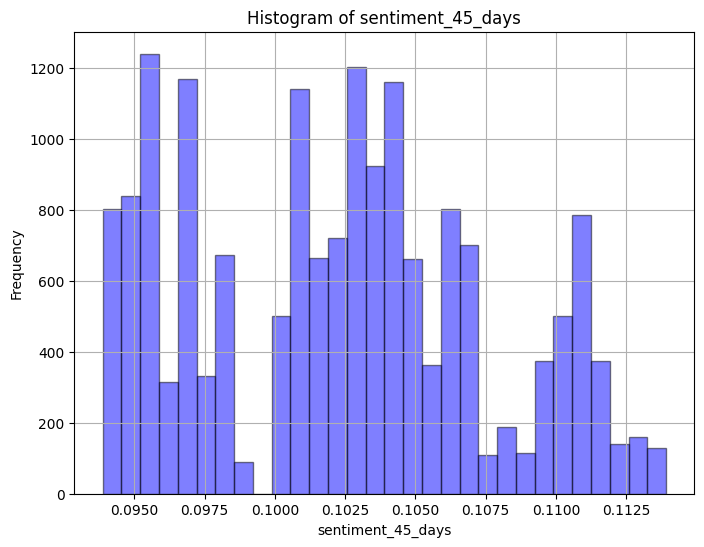

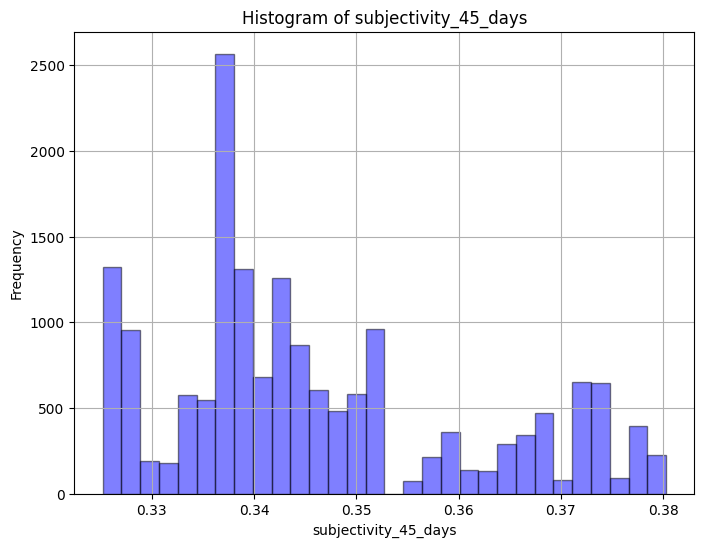

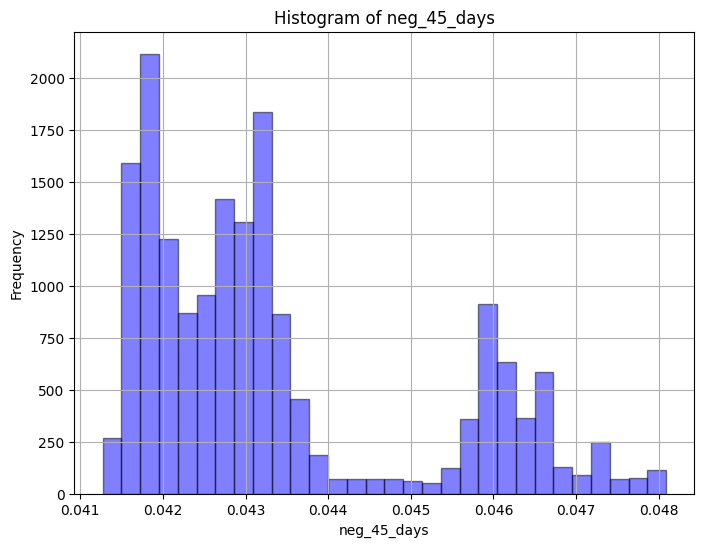

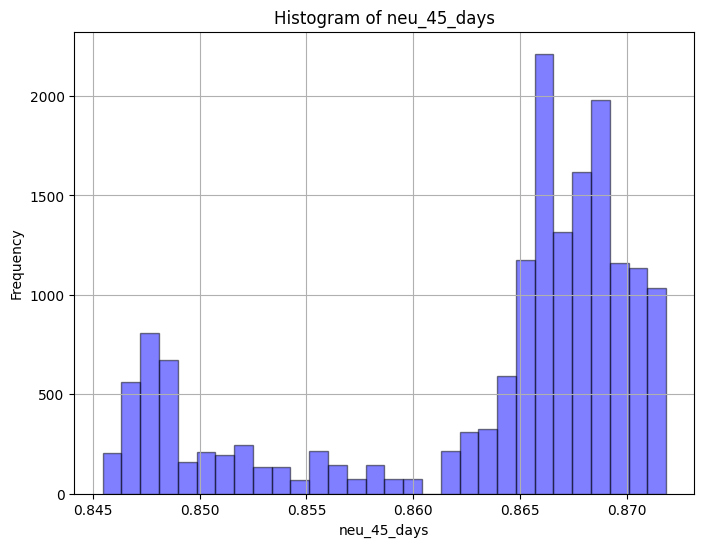

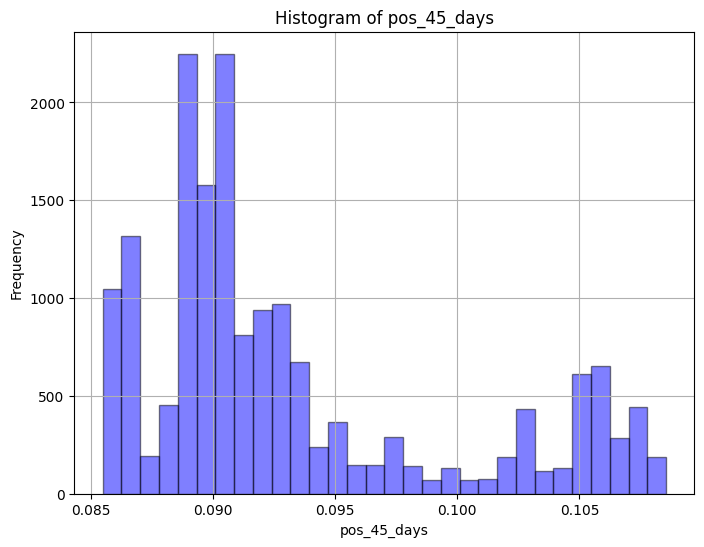

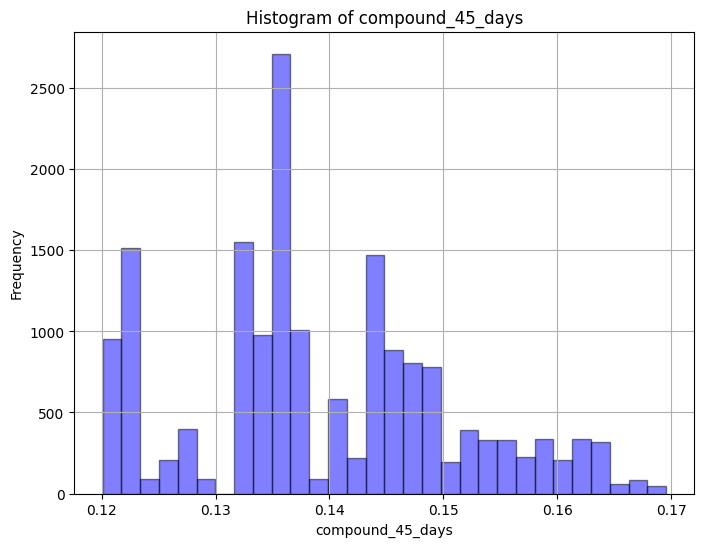

In [35]:
# Plot histograms of the sentiment variables
for var in sentiment_vars:
    plt.figure(figsize=(8,6))
    plt.hist(df_clean[var], bins=30, alpha=0.5, color='blue', edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [36]:
# Calculate the correlation matrix
correlation_matrix = df_clean[sentiment_vars + excess_return_vars].corr()
print(correlation_matrix)

                      sentiment_7_days  subjectivity_7_days  neg_7_days  \
sentiment_7_days              1.000000             0.694730   -0.217889   
subjectivity_7_days           0.694730             1.000000    0.357997   
neg_7_days                   -0.217889             0.357997    1.000000   
neu_7_days                   -0.476124            -0.839666   -0.625921   
pos_7_days                    0.663019             0.864212    0.342932   
compound_7_days               0.841149             0.724418   -0.228487   
sentiment_14_days             0.878147             0.708749   -0.048026   
subjectivity_14_days          0.657288             0.943293    0.336010   
neg_14_days                  -0.055643             0.441899    0.785129   
neu_14_days                  -0.531204            -0.855742   -0.541781   
pos_14_days                   0.656381             0.871139    0.374479   
compound_14_days              0.763029             0.760171   -0.027888   
sentiment_30_days        

### Now lets analize our Binary Variables 

We calculate the mean 'Excess_Return_' for each category (0 and 1) of the binary variable. This can give us an idea of how the 'Excess_Return_' differs between the two categories.

First we need to hot encode 'VC' since it has 3 categories. 

In [37]:
# Perform one-hot encoding on 'VC' column
df_clean = pd.get_dummies(df_clean, columns=['VC'])

# Show the first few rows of the new DataFrame
print(df_clean.head())


              Date Ticker  Offer date  Rollup  Dual  Internet  IPO Price  \
216659  2019-03-28   WTRE  2019-03-28     0.0   0.0       0.0      25.26   
216660  2019-03-28   SXTC  2019-01-04     0.0   0.0       0.0       4.00   
216661  2019-03-28   MDJH  2019-01-08     0.0   0.0       0.0       5.00   
216662  2019-03-28   BCOW  2019-01-09     0.0   0.0       0.0      10.00   
216663  2019-03-28    MTC  2019-01-08     0.0   0.0       0.0       4.00   

        Age at IPO  Excess_Return_1d  Excess_Return_1w  ...  compound_30_days  \
216659           5          0.000208          0.022772  ...          0.156603   
216660          13         -0.009199          0.096231  ...          0.156603   
216661           5         -0.020120         -0.056482  ...          0.156603   
216662          24          0.000375          0.036574  ...          0.156603   
216663          63         -0.014285         -0.017756  ...          0.156603   

        sentiment_45_days  subjectivity_45_days  neg_45_

In [38]:
df_clean['VC_0.0'] = df_clean['VC_0.0'].astype(float)
df_clean['VC_1.0'] = df_clean['VC_1.0'].astype(float)
df_clean['VC_2.0'] = df_clean['VC_2.0'].astype(float)

print(df_clean.head())

              Date Ticker  Offer date  Rollup  Dual  Internet  IPO Price  \
216659  2019-03-28   WTRE  2019-03-28     0.0   0.0       0.0      25.26   
216660  2019-03-28   SXTC  2019-01-04     0.0   0.0       0.0       4.00   
216661  2019-03-28   MDJH  2019-01-08     0.0   0.0       0.0       5.00   
216662  2019-03-28   BCOW  2019-01-09     0.0   0.0       0.0      10.00   
216663  2019-03-28    MTC  2019-01-08     0.0   0.0       0.0       4.00   

        Age at IPO  Excess_Return_1d  Excess_Return_1w  ...  compound_30_days  \
216659           5          0.000208          0.022772  ...          0.156603   
216660          13         -0.009199          0.096231  ...          0.156603   
216661           5         -0.020120         -0.056482  ...          0.156603   
216662          24          0.000375          0.036574  ...          0.156603   
216663          63         -0.014285         -0.017756  ...          0.156603   

        sentiment_45_days  subjectivity_45_days  neg_45_

In [39]:
print(df_clean.dtypes)

Date                     object
Ticker                   object
Offer date               object
Rollup                  float64
Dual                    float64
Internet                float64
IPO Price               float64
Age at IPO                int64
Excess_Return_1d        float64
Excess_Return_1w        float64
Excess_Return_1m        float64
Excess_Return_3m        float64
Excess_Return_6m        float64
Excess_Return_1y        float64
sentiment_7_days        float64
subjectivity_7_days     float64
neg_7_days              float64
neu_7_days              float64
pos_7_days              float64
compound_7_days         float64
sentiment_14_days       float64
subjectivity_14_days    float64
neg_14_days             float64
neu_14_days             float64
pos_14_days             float64
compound_14_days        float64
sentiment_30_days       float64
subjectivity_30_days    float64
neg_30_days             float64
neu_30_days             float64
pos_30_days             float64
compound

Mean 'Excess_Return_*' for each category of Rollup:
        Excess_Return_1d  Excess_Return_1w  Excess_Return_1m  \
Rollup                                                         
0.0            -0.000196         -0.002623         -0.018380   
1.0             0.005848          0.028291         -0.067385   

        Excess_Return_3m  Excess_Return_6m  
Rollup                                      
0.0            -0.111242         -0.244309  
1.0            -0.258117         -0.513664  


Mean 'Excess_Return_*' for each category of VC_0.0:
        Excess_Return_1d  Excess_Return_1w  Excess_Return_1m  \
VC_0.0                                                         
0.0             0.000692          0.002568         -0.000574   
1.0            -0.001053         -0.007766         -0.040008   

        Excess_Return_3m  Excess_Return_6m  
VC_0.0                                      
0.0            -0.087842         -0.229218  
1.0            -0.138574         -0.262146  


Mean 'Excess_Retur

<Figure size 800x600 with 0 Axes>

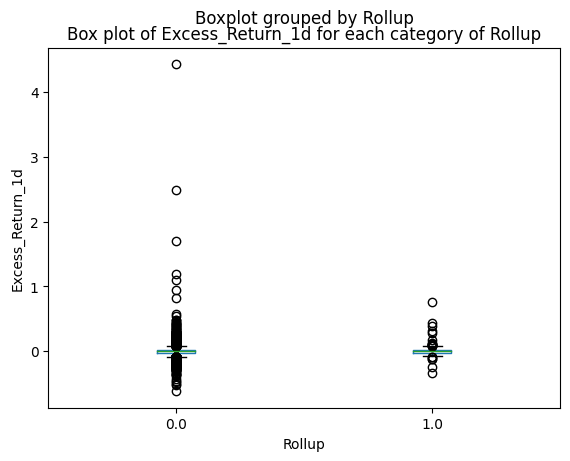

<Figure size 800x600 with 0 Axes>

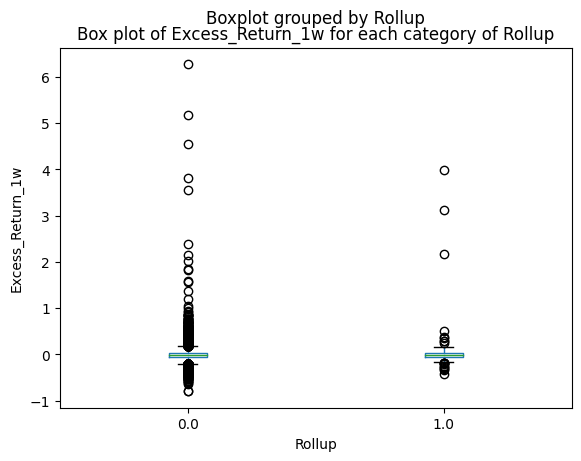

<Figure size 800x600 with 0 Axes>

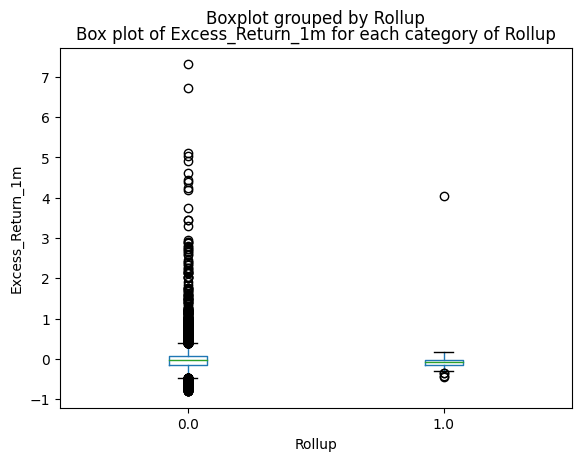

<Figure size 800x600 with 0 Axes>

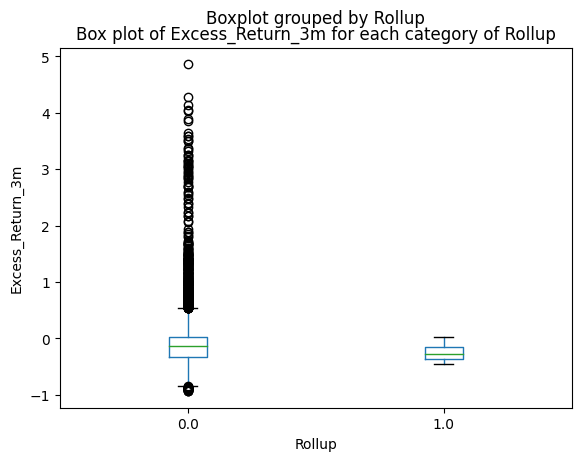

<Figure size 800x600 with 0 Axes>

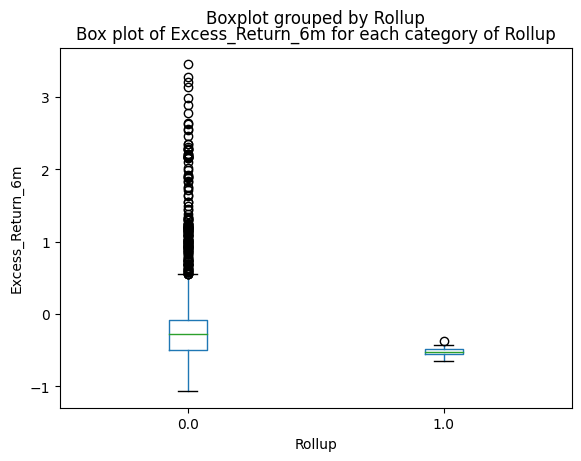

<Figure size 800x600 with 0 Axes>

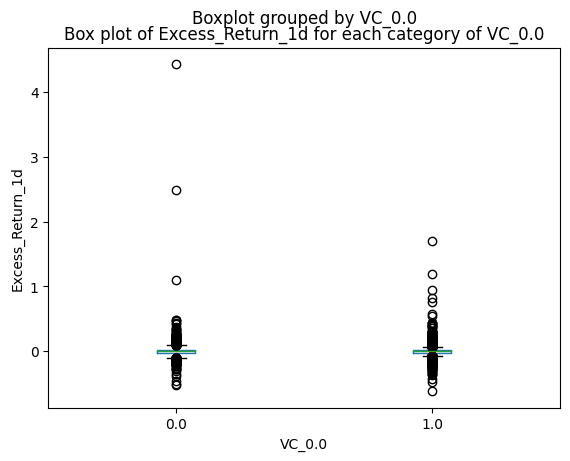

<Figure size 800x600 with 0 Axes>

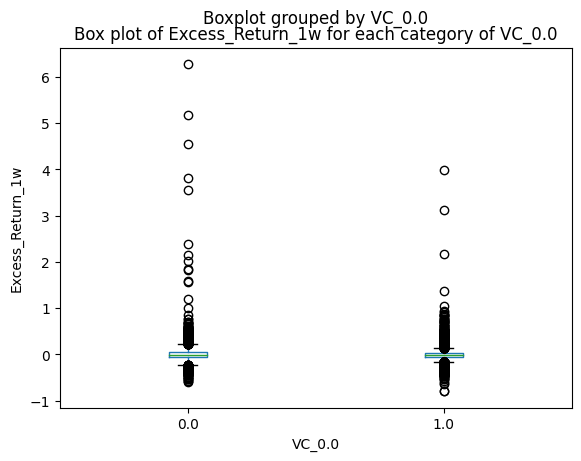

<Figure size 800x600 with 0 Axes>

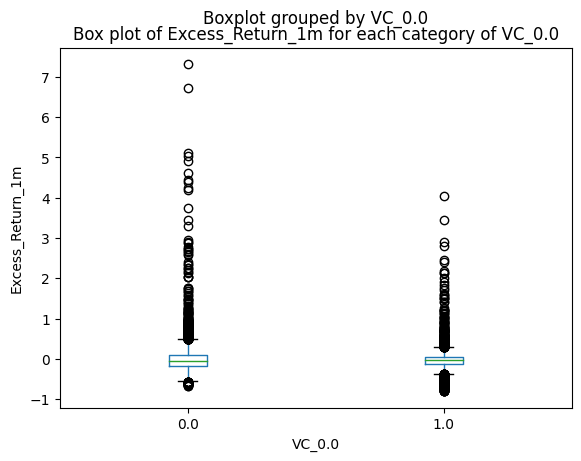

<Figure size 800x600 with 0 Axes>

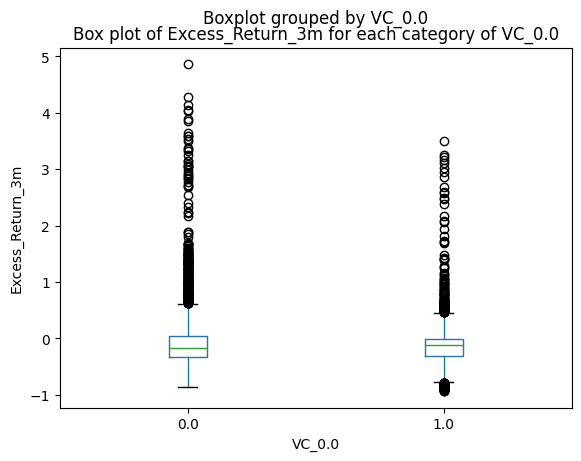

<Figure size 800x600 with 0 Axes>

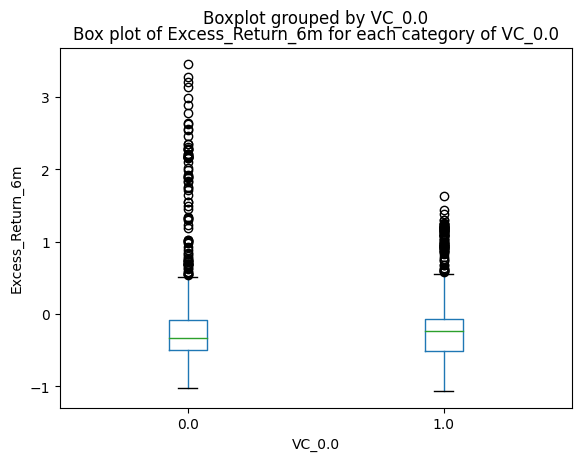

<Figure size 800x600 with 0 Axes>

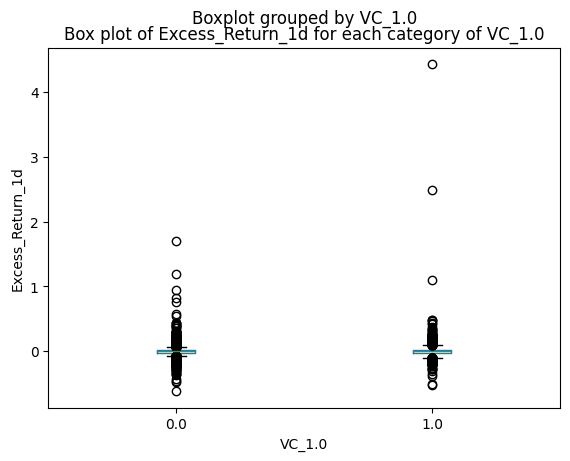

<Figure size 800x600 with 0 Axes>

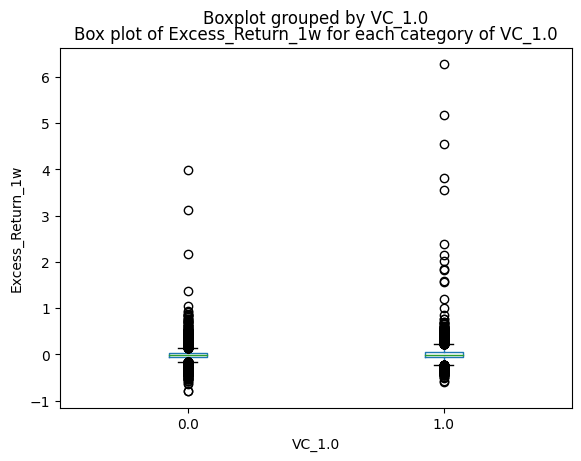

<Figure size 800x600 with 0 Axes>

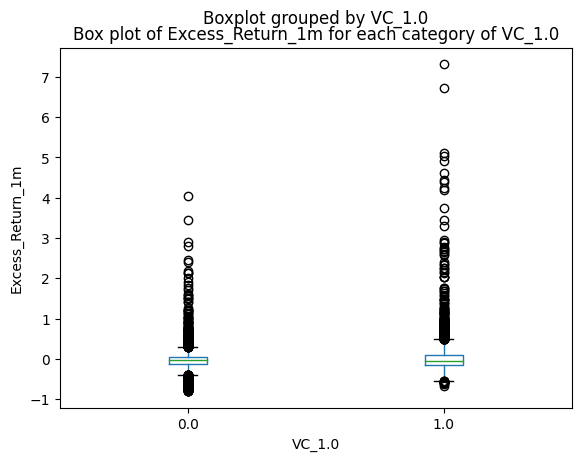

<Figure size 800x600 with 0 Axes>

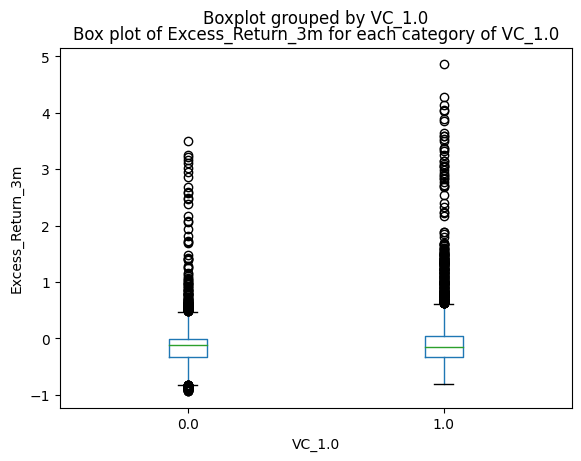

<Figure size 800x600 with 0 Axes>

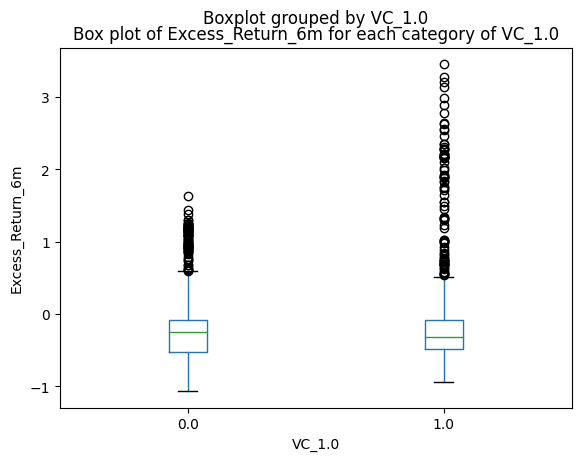

<Figure size 800x600 with 0 Axes>

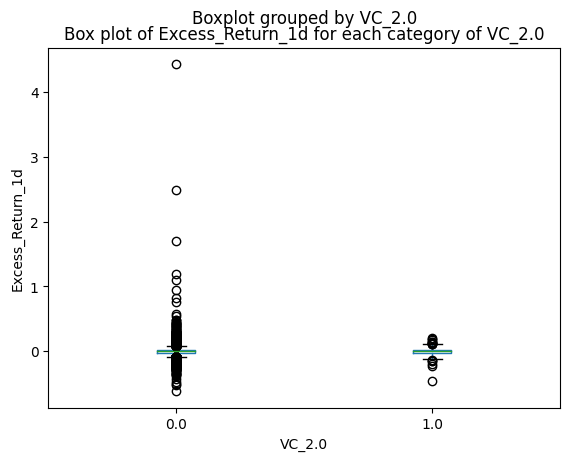

<Figure size 800x600 with 0 Axes>

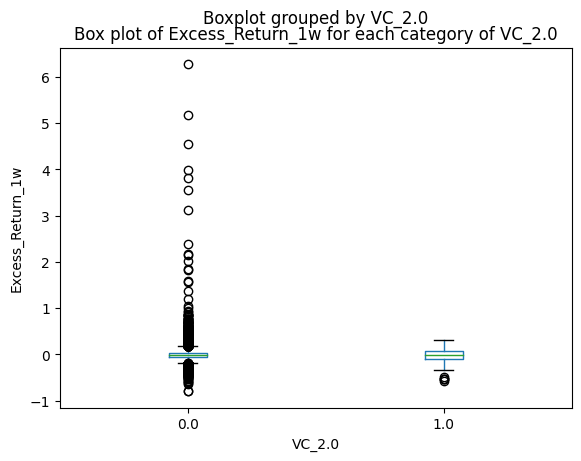

<Figure size 800x600 with 0 Axes>

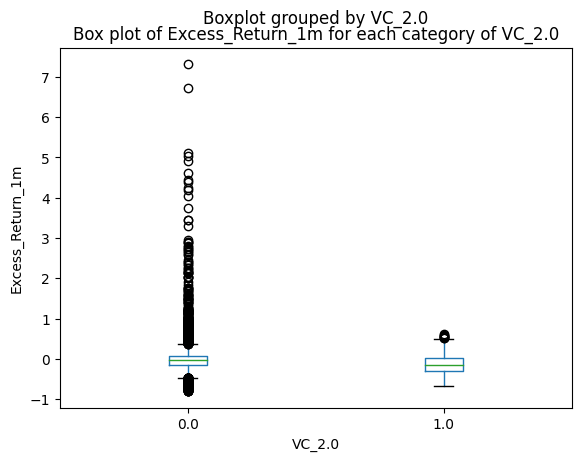

<Figure size 800x600 with 0 Axes>

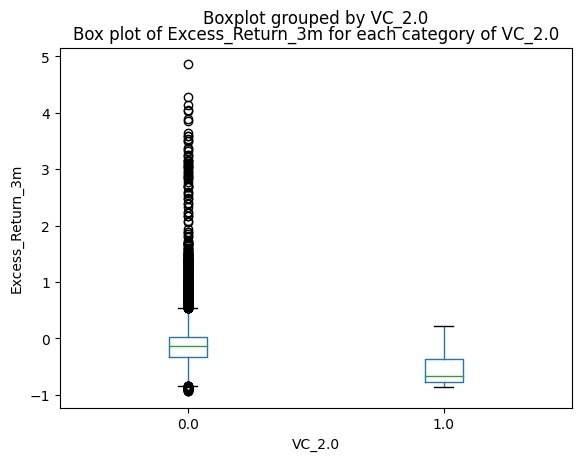

<Figure size 800x600 with 0 Axes>

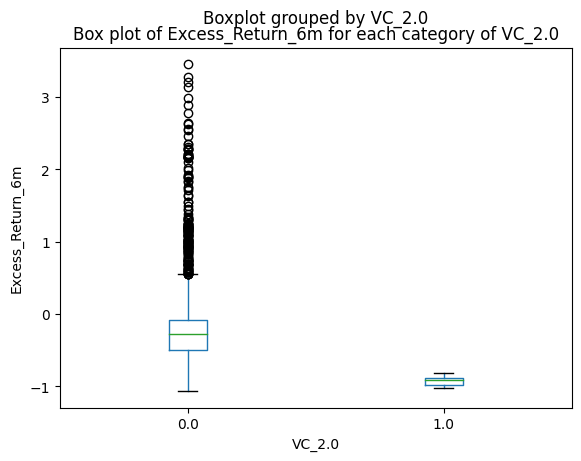

<Figure size 800x600 with 0 Axes>

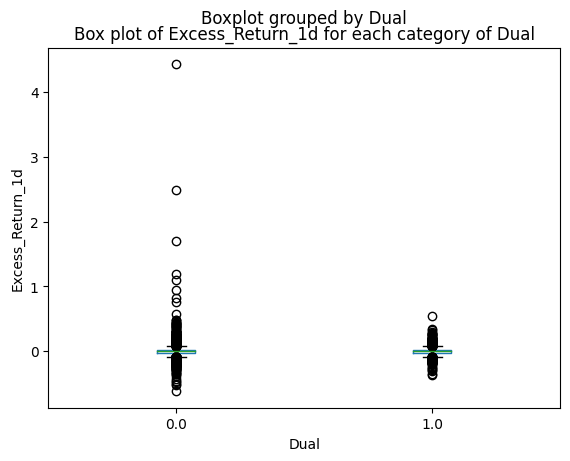

<Figure size 800x600 with 0 Axes>

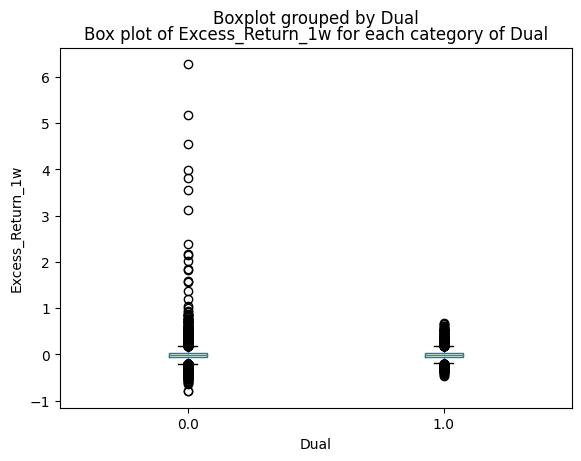

<Figure size 800x600 with 0 Axes>

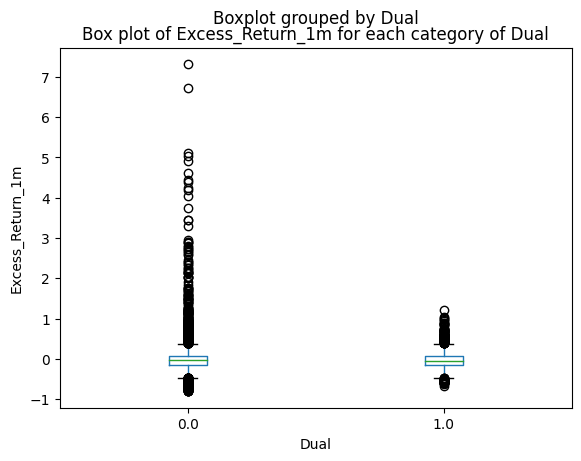

<Figure size 800x600 with 0 Axes>

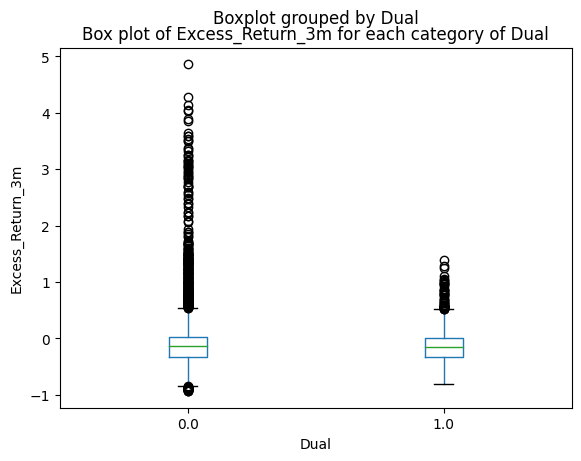

<Figure size 800x600 with 0 Axes>

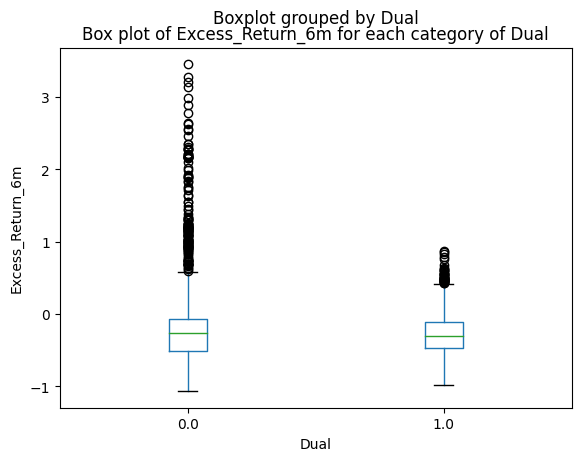

<Figure size 800x600 with 0 Axes>

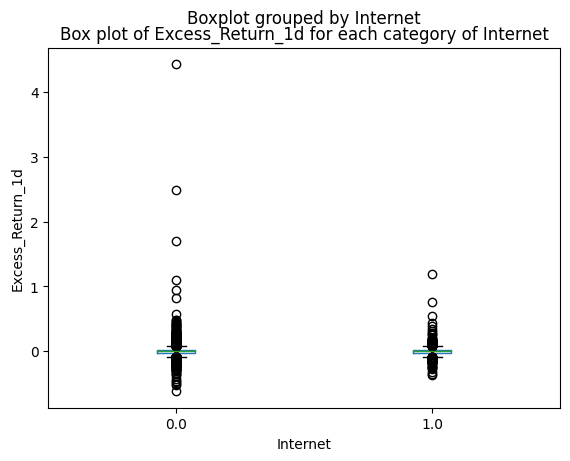

<Figure size 800x600 with 0 Axes>

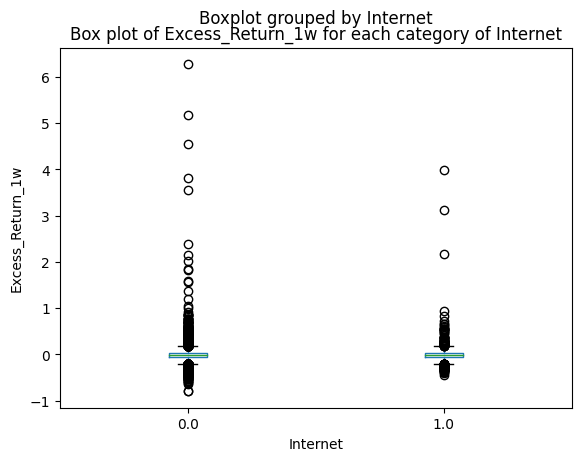

<Figure size 800x600 with 0 Axes>

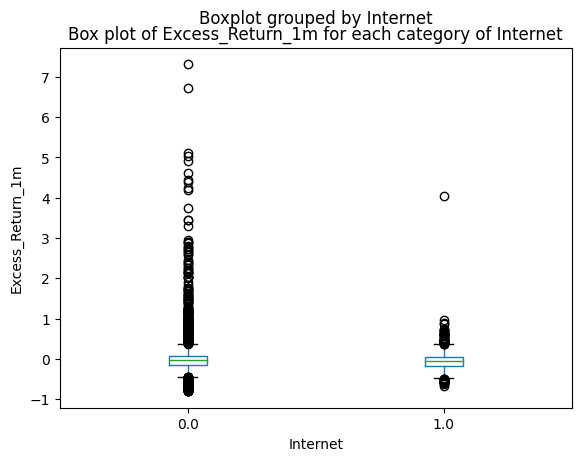

<Figure size 800x600 with 0 Axes>

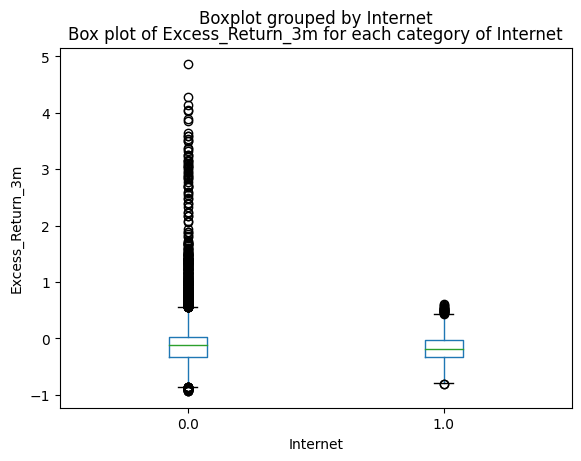

<Figure size 800x600 with 0 Axes>

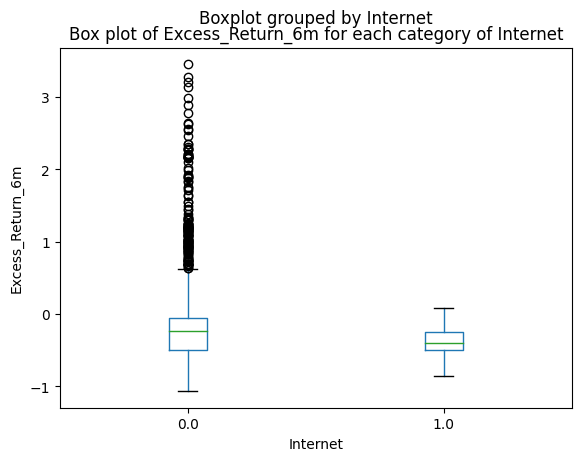

In [40]:
binary_vars = ['Rollup', 'VC_0.0', 'VC_1.0', 'VC_2.0', 'Dual', 'Internet']

# Calculate mean 'Excess_Return_*' for each category of the binary variables
for var in binary_vars:
    print(f"Mean 'Excess_Return_*' for each category of {var}:")
    print(df_clean.groupby(var)[excess_return_vars].mean())
    print("\n")

# Generate box plots of 'Excess_Return_*' for each category of the binary variables
for var in binary_vars:
    for return_var in excess_return_vars:
        plt.figure(figsize=(8,6))
        df_clean.boxplot(column=return_var, by=var, grid=False)
        plt.title(f'Box plot of {return_var} for each category of {var}')
        plt.xlabel(var)
        plt.ylabel(return_var)
        plt.show()


In [41]:
correlation_matrix = df_clean[binary_vars + excess_return_vars].corr()
correlation_matrix


,Rollup,VC_0.0,VC_1.0,VC_2.0,Dual,Internet,Excess_Return_1d,Excess_Return_1w,Excess_Return_1m,Excess_Return_3m,Excess_Return_6m
Rollup,1.000000,0.129221,-0.124492,-0.016406,-0.021817,-0.029424,0.010472,0.023382,-0.018357,-0.037171,-0.059009
VC_0.0,0.129221,1.000000,-0.963408,-0.126958,0.078111,-0.147693,-0.012849,-0.033542,-0.066768,-0.061703,-0.035328
VC_1.0,-0.124492,-0.963408,1.000000,-0.143559,-0.092721,0.165216,0.014829,0.038268,0.078745,0.090026,0.065278
VC_2.0,-0.016406,-0.126958,-0.143559,1.000000,0.054725,-0.066094,-0.007443,-0.017841,-0.045780,-0.122497,-0.147783
Dual,-0.021817,0.078111,-0.092721,0.054725,1.000000,0.331200,-0.011025,-0.022436,-0.043272,-0.062784,-0.051180
Internet,-0.029424,-0.147693,0.165216,-0.066094,0.331200,1.000000,-0.004936,-0.012160,-0.048173,-0.076901,-0.136212
Excess_Return_1d,0.010472,-0.012849,0.014829,-0.007443,-0.011025,-0.004936,1.000000,0.428976,0.225007,0.141806,0.068024
Excess_Return_1w,0.023382,-0.033542,0.038268,-0.017841,-0.022436,-0.012160,0.428976,1.000000,0.541424,0.326621,0.224218
Excess_Return_1m,-0.018357,-0.066768,0.078745,-0.045780,-0.043272,-0.048173,0.225007,0.541424,1.000000,0.605901,0.405537
Excess_Return_3m,-0.037171,-0.061703,0.090026,-0.122497,-0.062784,-0.076901,0.141806,0.326621,0.605901,1.000000,0.723262


Each of the binary variables (Rollup, VC, Dual, Internet) has a different mean excess return for each category, suggesting that these variables might be useful in predicting the excess return:

Rollup: The mean excess returns for the rollup category 1.0 are generally higher than for the category 0.0, except for the 1-month return. The 6-month return is particularly negative for both categories, but more so for the rollup firms.

VC_0.0, VC_1.0, VC_2.0: These are the one-hot encoded categories for the VC variable. For VC_0.0 and VC_1.0, the category 1.0 generally has more negative mean excess returns than the category 0.0. For VC_2.0 (Growth capiptal), the category 1.0 has considerably more negative mean excess returns than the category 0.0.

Dual (multiple shares class IPOs): Companies that are categorized as dual (1.0) have more negative mean excess returns across all time horizons compared to non-dual companies (0.0).

Internet: Internet companies (1.0) have more negative mean excess returns across all time horizons compared to non-internet companies (0.0).

## Descriptive Statistics for Excess-Return variables 

In [42]:
# Descriptive statistics for excess return variables
excess_return_descriptive = df_clean[excess_return_vars].describe()
print(excess_return_descriptive)

# Top 5 companies with highest Excess Returns for each time period
top_companies = {}
for var in excess_return_vars:
    top_companies[var] = df_clean[['Ticker', var]].sort_values(by=var, ascending=False).head(5)

# Display top companies
for key, value in top_companies.items():
    print(f"\nTop 5 companies with highest {key}:")
    print(value)

# Bottom 5 companies with lowest Excess Returns for each time period
bottom_companies = {}
for var in excess_return_vars:
    bottom_companies[var] = df_clean[['Ticker', var]].sort_values(by=var, ascending=True).head(5)

# Display bottom companies
for key, value in bottom_companies.items():
    print(f"\nBottom 5 companies with lowest {key}:")
    print(value)

       Excess_Return_1d  Excess_Return_1w  Excess_Return_1m  Excess_Return_3m  \
count      17050.000000      16518.000000      14430.000000       9596.000000   
mean          -0.000111         -0.002200         -0.018985         -0.112849   
std            0.067714          0.153593          0.294664          0.411081   
min           -0.618654         -0.801084         -0.806907         -0.940392   
25%           -0.022959         -0.057323         -0.152190         -0.331638   
50%           -0.001914         -0.008904         -0.040080         -0.137461   
75%            0.019277          0.038137          0.061099          0.014376   
max            4.428306          6.280172          7.316221          4.862762   

       Excess_Return_6m  
count       4018.000000  
mean          -0.247125  
std            0.464303  
min           -1.069275  
25%           -0.497946  
50%           -0.278297  
75%           -0.077173  
max            3.457023  

Top 5 companies with highest Excess

Correlation of 'Age at IPO' with 'Excess_Return_1d': -0.004114276029074992
Correlation of 'Age at IPO' with 'Excess_Return_1w': -0.010973873970093707
Correlation of 'Age at IPO' with 'Excess_Return_1m': -0.011350015044108886
Correlation of 'Age at IPO' with 'Excess_Return_3m': -0.030827604079978324
Correlation of 'Age at IPO' with 'Excess_Return_6m': -0.07502125901518014


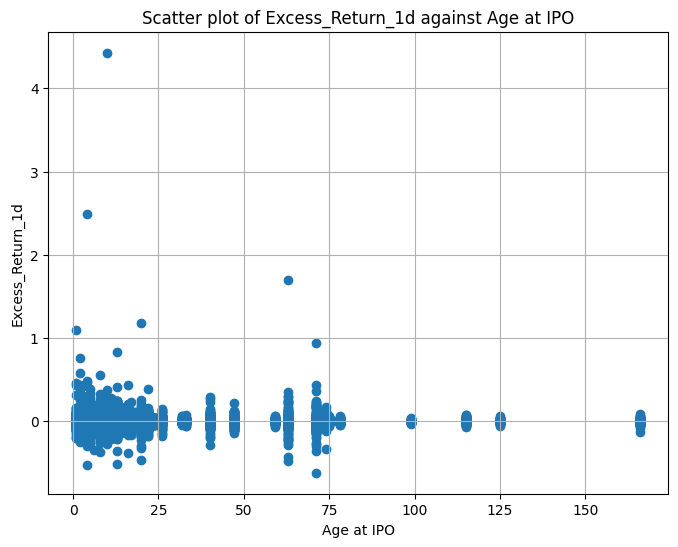

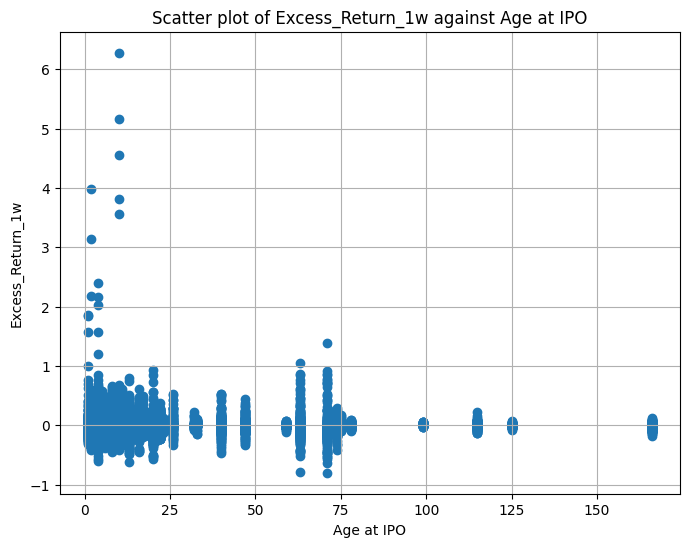

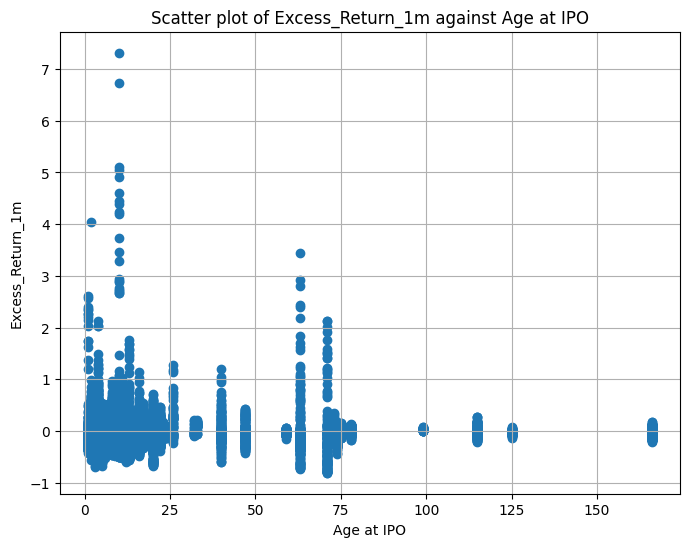

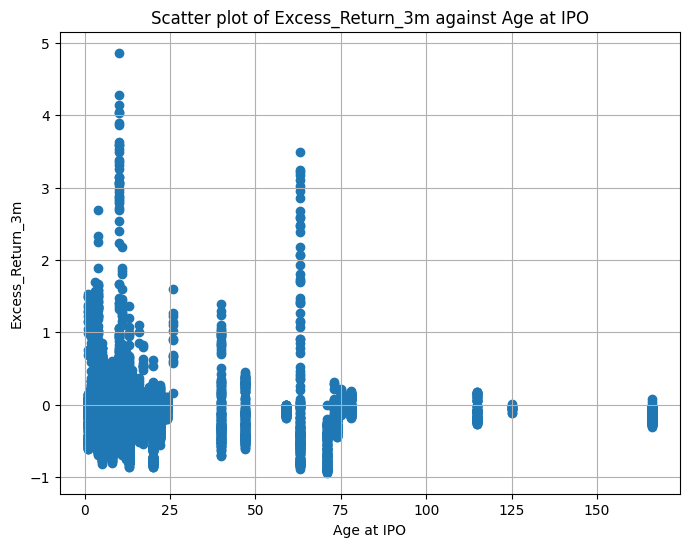

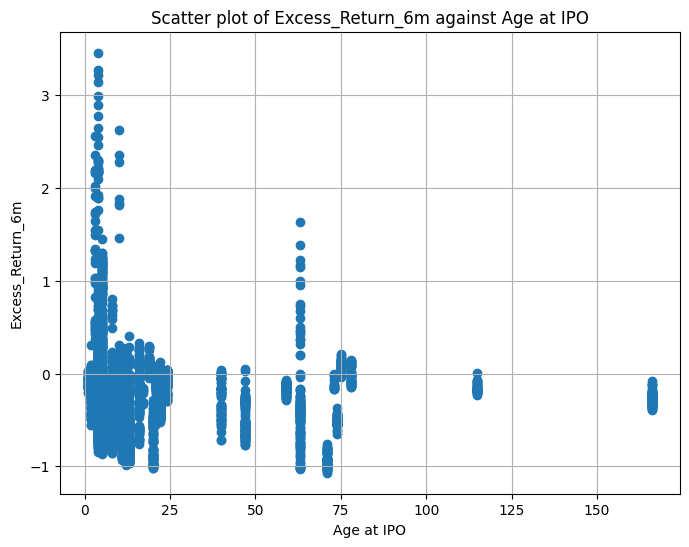

In [43]:
for var in excess_return_vars:
    corr = df_clean['Age at IPO'].corr(df_clean[var])
    print(f"Correlation of 'Age at IPO' with '{var}': {corr}")

# Generate scatter plots of 'Age at IPO' against each 'Excess_Return_*'
for var in excess_return_vars:
    plt.figure(figsize=(8,6))
    plt.scatter(df_clean['Age at IPO'], df_clean[var])
    plt.title(f'Scatter plot of {var} against Age at IPO')
    plt.xlabel('Age at IPO')
    plt.ylabel(var)
    plt.grid(True)
    plt.show()


### Outliers 
Lets look at data points with a Z-score greater than 3 or less than -3, which can be considered an outlier.

The absence of outliers means that the excess return variables do not contain any extremely unusual values that might skew our analysis.

In [45]:
# Calculate Z-scores for 'Excess_Return_*'
df_clean.loc[:, 'zscore_Excess_Return_1d'] = zscore(df_clean['Excess_Return_1d'])
df_clean.loc[:, 'zscore_Excess_Return_1w'] = zscore(df_clean['Excess_Return_1w'])
df_clean.loc[:, 'zscore_Excess_Return_1m'] = zscore(df_clean['Excess_Return_1m'])
df_clean.loc[:, 'zscore_Excess_Return_3m'] = zscore(df_clean['Excess_Return_3m'])
df_clean.loc[:, 'zscore_Excess_Return_6m'] = zscore(df_clean['Excess_Return_6m'])
df_clean.loc[:, 'zscore_Excess_Return_1y'] = zscore(df_clean['Excess_Return_1y'])

# Identify outliers
outliers_1d = df_clean[abs(df_clean['zscore_Excess_Return_1d']) > 3]
outliers_1w = df_clean[abs(df_clean['zscore_Excess_Return_1w']) > 3]
outliers_1m = df_clean[abs(df_clean['zscore_Excess_Return_1m']) > 3]
outliers_3m = df_clean[abs(df_clean['zscore_Excess_Return_3m']) > 3]
outliers_6m = df_clean[abs(df_clean['zscore_Excess_Return_6m']) > 3]
outliers_1y = df_clean[abs(df_clean['zscore_Excess_Return_1y']) > 3]

# Print number of outliers for each 'Excess_Return_*'
print(f"Number of outliers in 'Excess_Return_1d': {len(outliers_1d)}")
print(f"Number of outliers in 'Excess_Return_1w': {len(outliers_1w)}")
print(f"Number of outliers in 'Excess_Return_1m': {len(outliers_1m)}")
print(f"Number of outliers in 'Excess_Return_3m': {len(outliers_3m)}")
print(f"Number of outliers in 'Excess_Return_6m': {len(outliers_6m)}")
print(f"Number of outliers in 'Excess_Return_1y': {len(outliers_1y)}")


Number of outliers in 'Excess_Return_1d': 0
Number of outliers in 'Excess_Return_1w': 0
Number of outliers in 'Excess_Return_1m': 0
Number of outliers in 'Excess_Return_3m': 0
Number of outliers in 'Excess_Return_6m': 0
Number of outliers in 'Excess_Return_1y': 0


In [46]:
columns_to_drop = [
    'zscore_Excess_Return_1d',
    'zscore_Excess_Return_1w',
    'zscore_Excess_Return_1m',
    'zscore_Excess_Return_3m',
    'zscore_Excess_Return_6m',
    'zscore_Excess_Return_1y'
]

df_clean = df_clean.drop(columns_to_drop, axis=1)


In [47]:
df_numeric = df_clean.select_dtypes(include=[np.number])

# Calculate and display the correlation matrix of all numeric variables
correlation_matrix_numeric = df_numeric.corr()
print(correlation_matrix_numeric)


                        Rollup      Dual  Internet  IPO Price  Age at IPO  \
Rollup                1.000000 -0.021817 -0.029424  -0.013230    0.151013   
Dual                 -0.021817  1.000000  0.331200   0.211105   -0.027362   
Internet             -0.029424  0.331200  1.000000   0.349435   -0.135756   
IPO Price            -0.013230  0.211105  0.349435   1.000000   -0.042762   
Age at IPO            0.151013 -0.027362 -0.135756  -0.042762    1.000000   
Excess_Return_1d      0.010472 -0.011025 -0.004936   0.000793   -0.004114   
Excess_Return_1w      0.023382 -0.022436 -0.012160   0.007276   -0.010974   
Excess_Return_1m     -0.018357 -0.043272 -0.048173   0.024505   -0.011350   
Excess_Return_3m     -0.037171 -0.062784 -0.076901   0.030022   -0.030828   
Excess_Return_6m     -0.059009 -0.051180 -0.136212   0.075142   -0.075021   
Excess_Return_1y           NaN       NaN       NaN   0.999599   -0.999599   
sentiment_7_days      0.014417  0.001403 -0.016436  -0.028112    0.019431   

In [48]:
print(df_clean.head())

              Date Ticker  Offer date  Rollup  Dual  Internet  IPO Price  \
216659  2019-03-28   WTRE  2019-03-28     0.0   0.0       0.0      25.26   
216660  2019-03-28   SXTC  2019-01-04     0.0   0.0       0.0       4.00   
216661  2019-03-28   MDJH  2019-01-08     0.0   0.0       0.0       5.00   
216662  2019-03-28   BCOW  2019-01-09     0.0   0.0       0.0      10.00   
216663  2019-03-28    MTC  2019-01-08     0.0   0.0       0.0       4.00   

        Age at IPO  Excess_Return_1d  Excess_Return_1w  ...  compound_30_days  \
216659           5          0.000208          0.022772  ...          0.156603   
216660          13         -0.009199          0.096231  ...          0.156603   
216661           5         -0.020120         -0.056482  ...          0.156603   
216662          24          0.000375          0.036574  ...          0.156603   
216663          63         -0.014285         -0.017756  ...          0.156603   

        sentiment_45_days  subjectivity_45_days  neg_45_

Here are a few observations from our data:

1. The 'Excess_Return_*' variables are positively correlated with each other, as expected. The correlation decreases as the time period between the variables increases. For example, 'Excess_Return_1d' and 'Excess_Return_1w' have a higher correlation than 'Excess_Return_1d' and 'Excess_Return_1y'.

2. The 'Age at IPO' variable is negatively correlated with 'VC' and 'Internet', and positively correlated with 'Rollup'. This suggests that companies that are part of a roll-up are typically older at the time of their IPO, while VC-backed and Internet companies are typically younger.

3. The 'IPO Price' variable is positively correlated with 'VC', 'Dual', and 'Internet'. This suggests that companies that are VC-backed, are part of a dual track process, or are in the Internet industry, typically have higher IPO prices.

4. The sentiment scores ('sentiment_days' and 'compound_days') are positively correlated with each other. This is expected as they are both measures of sentiment over different time periods.

5. The sentiment scores have a small positive correlation with the 'Excess_Return_*' variables. This suggests that higher sentiment scores might be associated with higher excess returns, but the correlation is not very strong.

6. The sentiment scores are negatively correlated with 'Age at IPO'. This suggests that older companies might have lower sentiment scores.

In [51]:
print(df_clean.columns)

Index(['Date', 'Ticker', 'Offer date', 'Rollup', 'Dual', 'Internet',
       'IPO Price', 'Age at IPO', 'Excess_Return_1d', 'Excess_Return_1w',
       'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m',
       'Excess_Return_1y', 'sentiment_7_days', 'subjectivity_7_days',
       'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
       'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
       'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
       'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
       'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
       'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days',
       'VC_0.0', 'VC_1.0', 'VC_2.0'],
      dtype='object')


### Pre-processing and Training Data

In [53]:
# Define predictors and target variables

predictors = [
    'Rollup', 'Dual', 'Internet',
    'IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days',
    'VC_0.0', 'VC_1.0', 'VC_2.0'
]


target = ['Excess_Return_1d', 'Excess_Return_1w', 'Excess_Return_1m', 'Excess_Return_3m', 'Excess_Return_6m']


In [54]:
# Split into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(df_clean[predictors], df_clean[target], test_size=0.2, shuffle=False)


### Standardize numeric variables using a StandardScaler()

In [55]:
# Standardize continuous variables
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train[['IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days']])

StandardScaler()

In [56]:
# Apply transform to both the training set and the test set.

X_train[['IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days']] = scaler.transform(X_train[['IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days']])


X_test[['IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days']] = scaler.transform(X_test[['IPO Price', 'Age at IPO', 'sentiment_7_days', 'subjectivity_7_days',
    'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days',
    'sentiment_14_days', 'subjectivity_14_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days', 'compound_14_days', 'sentiment_30_days',
    'subjectivity_30_days', 'neg_30_days', 'neu_30_days', 'pos_30_days',
    'compound_30_days', 'sentiment_45_days', 'subjectivity_45_days',
    'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days']])


In [57]:
print(df_clean.head())

              Date Ticker  Offer date  Rollup  Dual  Internet  IPO Price  \
216659  2019-03-28   WTRE  2019-03-28     0.0   0.0       0.0      25.26   
216660  2019-03-28   SXTC  2019-01-04     0.0   0.0       0.0       4.00   
216661  2019-03-28   MDJH  2019-01-08     0.0   0.0       0.0       5.00   
216662  2019-03-28   BCOW  2019-01-09     0.0   0.0       0.0      10.00   
216663  2019-03-28    MTC  2019-01-08     0.0   0.0       0.0       4.00   

        Age at IPO  Excess_Return_1d  Excess_Return_1w  ...  compound_30_days  \
216659           5          0.000208          0.022772  ...          0.156603   
216660          13         -0.009199          0.096231  ...          0.156603   
216661           5         -0.020120         -0.056482  ...          0.156603   
216662          24          0.000375          0.036574  ...          0.156603   
216663          63         -0.014285         -0.017756  ...          0.156603   

        sentiment_45_days  subjectivity_45_days  neg_45_

Creating separate models that use TextBlob sentiment or the VADER compound score will allow us to determine which sentiment measure contributes more to the model's performance. We will continue this in the modelling section... 

In [58]:
# Define predictor variables, for both TextBlob sentiment or VADER compound
predictors_TextBlob = ['Rollup', 'Dual', 'Internet',
    'IPO Price', 'Age at IPO', 'VC_0.0', 'VC_1.0', 'VC_2.0', 'sentiment_7_days', 'subjectivity_7_days', 'sentiment_14_days', 'subjectivity_14_days', 'sentiment_30_days', 'subjectivity_30_days', 'sentiment_45_days', 'subjectivity_45_days' ]


predictors_VADER = ['Rollup', 'Dual', 'Internet', 'IPO Price', 'Age at IPO', 'VC_0.0', 'VC_1.0', 'VC_2.0', 'neg_7_days', 'neu_7_days', 'pos_7_days', 'compound_7_days', 'neg_14_days',
    'neu_14_days', 'pos_14_days' 'compound_14_days', 'neg_30_days', 'neu_30_days', 'pos_30_days', 'compound_30_days', 'neg_45_days', 'neu_45_days', 'pos_45_days', 'compound_45_days']

In [59]:
df_clean.to_csv('df_IPO.csv')